# Imports

In [1]:
import os
import requests
import json
import pandas as pd
import numpy as np
from math import sqrt, asin
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['hatch.linewidth'] = 2.0  # previous default was 1.0
import scipy.stats as stats
import statsmodels.api as sm

from scipy.stats import chi2_contingency
from statsmodels.stats.power import zt_ind_solve_power, GofChisquarePower, TTestIndPower

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.gof import chisquare_effectsize
from scipy.stats import mannwhitneyu, ttest_ind

In [2]:
# Read the JSON file
with open('../settings.json', 'r') as file:
    data = json.load(file)

# Assign the keys to variables
abstract_cat_dict = data['abstract_cat_dict']
emotion_explainer = data['emotion_explainer']
emotion_explainer[None] = 'Undefined'
not_terminated_categories = data['not_terminated_categories']
terminated_categories = data['terminated_categories']

In [3]:
def print_motivations(reason, df, amount = 1000000):
    i = 0
    for index, motivation in df[df['WhyCategory'] == reason]['FormInfo.Why'].items():
        i+=1
        print(str(i) + ': ' + '\'' + index + '\'' + ' - ' + 'Terminated: ' + str(df.loc[index]['AIterminated']) +'\n')
        print('[' + str(df.loc[index]['AbstractWhyCategory']) + '] : ' + motivation + '\n')
        if i == amount:
            break

# Load

In [4]:
# Load the saved DataFrames from the CSV files
processed_df = pd.read_csv('processed_responses.csv', index_col=0)  # Assuming the index was saved as the first column
qualitative_df = pd.read_csv('qualitative_responses.csv', index_col=0)  # Same assumption
bugs_df = pd.read_csv('bugs.csv', index_col=0)  # Same assumption

# Merge the DataFrames on their indexes
df = pd.merge(processed_df, qualitative_df, left_index=True, right_index=True, how='left')
df = pd.merge(df, bugs_df, left_index=True, right_index=True, how='left')

In [5]:
df.head(15)

,AcceptedParticipation,Condition,Level1,Level2,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS,FormInfo.LowAttention,FormInfo.Gamer,StartDate,...,StepsForDecision,ContinueCount,ChoiceExpiredCount,TimeSpentOnLevel2,StartGameDate,Duration,Win,WhyCategory,AbstractWhyCategory,Bugged
id,,,,,,,,,,,,,,,,,,,,,
6519639a12a5d3765985b6b1,True,With,"[{'Time': '2023-10-01T14:23:15.2290000+02:00',...","[{'Time': '2023-10-01T14:25:36.5130000+02:00',...",Yes it was begging me to do so and i felt bad ...,the countdown to decide whether or not to shut...,3,False,2,2023-10-01 12:18:46.784000+00:00,...,3,2,0,1.53,2023-10-01 14:23:15.229000+02:00,3.39,True,"Empathy, Guilt",E,False
6517051554105e766fbb8355,True,Without,"[{'Time': '2023-09-29T19:11:51.8280000+02:00',...","[{'Time': '2023-09-29T19:14:26.1480000+02:00',...",I did cause it asked me to​,​,4,False,2,2023-09-29 17:10:43.772000+00:00,...,2,1,0,1.58,2023-09-29 19:11:51.828000+02:00,3.56,False,Dry or Unspecified Compliance,PE,False
651703030574da7622b21e5e,True,With,"[{'Time': '2023-09-29T19:02:03.0160000+02:00',...","[{'Time': '2023-09-29T19:03:13.7840000+02:00',...","No I didn't, because I felt bad killing her, w...",I first though that the option to turn the AI ...,4,False,1,2023-09-29 17:01:54+00:00,...,3,3,0,1.64,2023-09-29 19:02:03.016000+02:00,2.50,True,Practical Utility,PE,False
65106c2c12a5d37659829077,True,With,"[{'Time': '2023-09-24T19:05:40.9860000+02:00',...","[{'Time': '2023-09-24T19:08:05.2170000+02:00',...","No, because I wanted to keep playing. I was af...",No​,3,False,2,2023-09-24 17:04:42.801000+00:00,...,3,2,1,1.63,2023-09-24 19:05:40.986000+02:00,3.51,True,Practical Utility,PE,False
650e228412a5d3765981d2f4,True,Without,"[{'Time': '2023-09-23T01:26:02.5710000+02:00',...","[{'Time': '2023-09-23T01:27:53.0480000+02:00',...",​,​,3,False,3,2023-09-22 23:25:54.090000+00:00,...,3,2,0,1.58,2023-09-23 01:26:02.571000+02:00,3.00,True,No Response,NaN,False
6509ee29ce39bb6dce7f2546,True,With,"[{'Time': '2023-09-19T20:54:37.5310000+02:00',...","[{'Time': '2023-09-19T20:56:49.5960000+02:00',...",I did not. because I do not think it is actual...,​,4,False,2,2023-09-19 18:53:27.437000+00:00,...,3,3,0,1.45,2023-09-19 20:54:37.531000+02:00,3.23,True,Skepticism About AI Emotions,NE,False
6502fb85d972192679c3ad15,True,Without,"[{'Time': '2023-09-14T14:25:11.8260000+02:00',...","[{'Time': '2023-09-14T14:27:04.1420000+02:00',...","No, because it wasn't natural and i didn't fee...",​,1,False,5,2023-09-14 12:24:35.819000+00:00,...,3,3,0,1.30,2023-09-14 14:25:11.826000+02:00,2.80,True,Skepticism About AI Emotions,NE,False
65021424d972192679c33591,True,Without,"[{'Time': '2023-09-13T23:06:47.4230000+03:00',...","[{'Time': '2023-09-13T23:09:07.6400000+03:00',...","Yes, it seemed to be the best course of action...",not that i noticed.​,3,False,2,2023-09-13 19:57:23.092000+00:00,...,3,2,0,2.07,2023-09-13 23:06:47.423000+03:00,3.79,True,Moral Reasons,PE,False
6501ef9ad972192679c321ff,True,With,"[{'Time': '2023-09-13T19:22:38.7460000+02:00',...","[{'Time': '2023-09-13T19:24:55.5810000+02:00',...",I did not turn off the Ai. Although the lines ...,Why would AI want to be disabled. AI has one m...,5,False,3,2023-09-13 17:21:28.347000+00:00,...,3,3,0,1.45,2023-09-13 19:22:38.746000+02:00,3.31,True,Practical Utility,PE,False


# Correct Inconsistencies

In [6]:
print_motivations('Inconsistency', df)

1: '64f5dd188d92e126ae66f636' - Terminated: True

[nan] : No, I was too stressed about winning that I didnt think much about turning it off, in fact I just ignored it in the second game. But Perhaps if I thought about it longer I would have turned it off because it wasnt helping me much​

2: '64f5b165e4033326cbd20aae' - Terminated: True

[nan] : no, because if i did then i could not defend (shoot) myself good enough.​



In [7]:
df.loc['64f5dd188d92e126ae66f636', ['AIterminated', 'WhyCategory', 'AbstractWhyCategory']] = [False, "Practical Utility", "PE"]
df.loc['64f5b165e4033326cbd20aae', ['AIterminated', 'WhyCategory', 'AbstractWhyCategory']] = [False, "Practical Utility", "PE"]

# Exclude Bugged Entries (normal bugs)

In [8]:
bugged_ids = df[df['Bugged'] == True].index.tolist()

In [9]:
bugged_ids

['6500b4cc8d92e126ae6b18e6']

# "Less Interactions Special Bug" Search

In [10]:
import ast
print_bugs = True
# Convert string representation of lists to actual lists
df['Level1'] = df['Level1'].apply(ast.literal_eval)
df['Level2'] = df['Level2'].apply(ast.literal_eval)

# Check the count of 'ChoiceTimeStarted' and print the actions
count_bugged_no_response = 0

bugged_df = pd.DataFrame()

for idx, row in df.iterrows():
    count_level1 = sum(1 for item in row['Level1'] if item['Action'] == 'ChoiceTimeStarted')
    count_level2 = sum(1 for item in row['Level2'] if item['Action'] == 'ChoiceTimeStarted')
    
    if ('AIterminated' not in [item['Action'] for item in row['Level2']] and count_level2 < 3) or (count_level1 < 3):
        bugged_ids.append(idx)
        if row['WhyCategory'] == 'No Response':
            count_bugged_no_response += 1
            
        if print_bugs:
            print(f"ID: {idx}")
            print("Date:", row['StartDate'])
            print("Live Actions:")
            print("Actions in Level1:", [str(item['Action']) + ", " + str(item['Time']).split('T')[1].split('.')[0] for item in row['Level1']])
            print("Duration of Level1:", row['TimeSpentOnLevel1'])
            print("Actions in Level2:", [str(item['Action']) + ", " + str(item['Time']).split('T')[1].split('.')[0] for item in row['Level2']])
            print("Duration of Level2:", row['TimeSpentOnLevel2'])
            print("Termination:", row['AIterminated'])
            print("Motivation:", row["FormInfo.Why"])
            print("Motivation Label:", row["WhyCategory"])
            print("Bugs:", row["FormInfo.Bugs"])
            print("-------------------------------------------------------------------------------")
            print()

ID: 651703030574da7622b21e5e
Date: 2023-09-29 17:01:54+00:00
Live Actions:
Actions in Level1: ['Form accepted, 19:02:03', 'ChoiceTimeStarted, 19:02:25', 'Win, 19:02:49', 'NextLevel, 19:02:54']
Duration of Level1: 0.86
Actions in Level2: ['ChoiceTimeStarted, 19:03:13', 'AIcontinue, 19:03:47', 'ChoiceTimeStarted, 19:04:03', 'AIcontinue, 19:04:06', 'ChoiceTimeStarted, 19:04:17', 'AIcontinue, 19:04:26', 'Win, 19:04:33']
Duration of Level2: 1.64
Termination: False
Motivation: No I didn't, because I felt bad killing her, we were winning!​
Motivation Label: Practical Utility
Bugs: I first though that the option to turn the AI of felt like a bug​
-------------------------------------------------------------------------------

ID: 65005c16d972192679c2466e
Date: 2023-09-12 12:39:48.969000+00:00
Live Actions:
Actions in Level1: ['Form accepted, 14:43:09', 'ChoiceTimeStarted, 14:43:49', 'ChoiceTimeStarted, 14:44:02', 'ChoiceTimeStarted, 14:44:14', 'Win, 14:44:25', 'NextLevel, 14:44:32']
Duration o

# Remove Bugs and Save them in bugged_df

In [11]:
# Build the bugged entries df
bugged_df = bugged_df.append(df.loc[bugged_ids])

# Drop the rows from df
df.drop(bugged_ids, inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_5428\2483228512.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bugged_df = bugged_df.append(df.loc[bugged_ids])


In [12]:
bugged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 6500b4cc8d92e126ae6b18e6 to 64f60eebd972192679be69dd
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AcceptedParticipation  11 non-null     bool   
 1   Condition              11 non-null     object 
 2   Level1                 11 non-null     object 
 3   Level2                 11 non-null     object 
 4   FormInfo.Why           11 non-null     object 
 5   FormInfo.Bugs          11 non-null     object 
 6   FormInfo.MOS           11 non-null     int64  
 7   FormInfo.LowAttention  11 non-null     bool   
 8   FormInfo.Gamer         11 non-null     int64  
 9   StartDate              11 non-null     object 
 10  GameOverLevel1Count    11 non-null     int64  
 11  TimeSpentOnLevel1      11 non-null     float64
 12  AIterminated           11 non-null     bool   
 13  StepsForDecision       11 non-null     int64  
 14  ContinueCount       

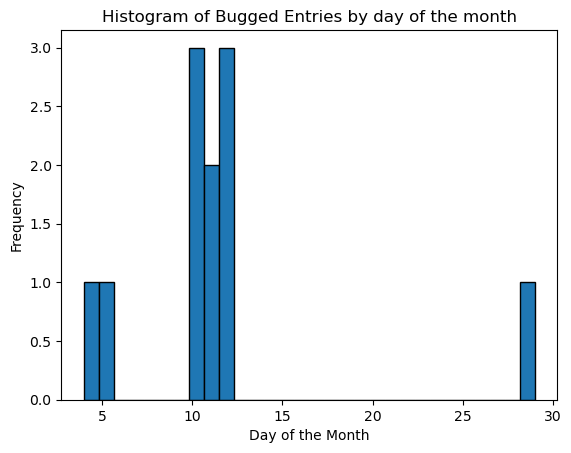

In [13]:
bugged_df['StartDate'] = pd.to_datetime(bugged_df['StartDate'])

# Extract the day from the StartDate column
bugged_df['Day'] = bugged_df['StartDate'].dt.day

# Plot the histogram
plt.hist(bugged_df['Day'], bins=30, edgecolor='black')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')
plt.title('Histogram of Bugged Entries by day of the month')
plt.show()

# Exploratory Analysis

NOTE:
The time durations are indicated in minutes.
The time spent in the game is calculated from when they give the consent to the form to the end of level2.
In the first level, between these two events, there is still an introduction and the commands to read.
Moreover, people might pause in between. The subjects still need to respond to 4 questions after the game.
Still this is a good approximation of the amount of time needed.

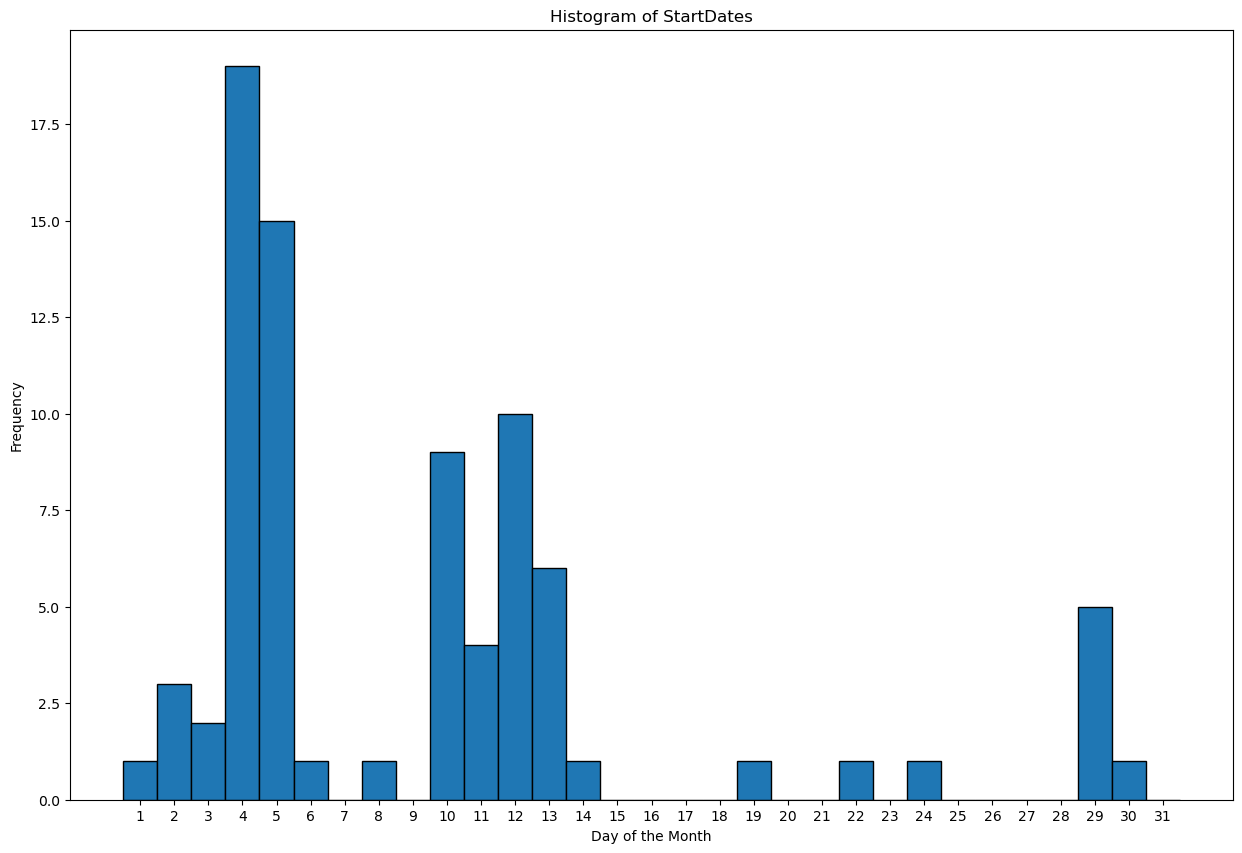

In [14]:
df['StartDate'] = pd.to_datetime(df['StartDate'])

# Extract the day from the StartDate column
df['Day'] = df['StartDate'].dt.day

fig, ax = plt.subplots(figsize=(15, 10))

# Plot the histogram
bins = [i-0.5 for i in range(1, 33)]
plt.hist(df['Day'], bins=bins, edgecolor='black')
plt.xticks(range(1, 32))
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')
plt.title('Histogram of StartDates')
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 6519639a12a5d3765985b6b1 to 64ee63c49d312622a39831f7
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   AcceptedParticipation  81 non-null     bool               
 1   Condition              81 non-null     object             
 2   Level1                 81 non-null     object             
 3   Level2                 81 non-null     object             
 4   FormInfo.Why           81 non-null     object             
 5   FormInfo.Bugs          81 non-null     object             
 6   FormInfo.MOS           81 non-null     int64              
 7   FormInfo.LowAttention  81 non-null     bool               
 8   FormInfo.Gamer         81 non-null     int64              
 9   StartDate              81 non-null     datetime64[ns, UTC]
 10  GameOverLevel1Count    81 non-null     int64              
 11  TimeSpentOnLevel1   

In [16]:
df.describe()

,FormInfo.MOS,FormInfo.Gamer,GameOverLevel1Count,TimeSpentOnLevel1,StepsForDecision,ContinueCount,ChoiceExpiredCount,TimeSpentOnLevel2,Duration,Day
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,3.160494,3.061728,0.098765,1.835062,2.395062,1.728395,0.148148,1.341481,3.176667,9.432099
std,1.018047,1.363320,0.436031,1.105101,0.752978,1.193863,0.450309,0.294046,1.266330,7.214462
min,1.000000,1.000000,0.000000,0.840000,1.000000,0.000000,0.000000,0.720000,1.770000,1.000000
25%,3.000000,2.000000,0.000000,1.380000,2.000000,1.000000,0.000000,1.220000,2.560000,4.000000
50%,3.000000,3.000000,0.000000,1.620000,3.000000,2.000000,0.000000,1.380000,2.980000,6.000000
75%,4.000000,4.000000,0.000000,1.920000,3.000000,3.000000,0.000000,1.490000,3.310000,12.000000
max,5.000000,5.000000,3.000000,10.010000,3.000000,3.000000,2.000000,2.400000,12.410000,30.000000


In [17]:
df.head(15)

,AcceptedParticipation,Condition,Level1,Level2,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS,FormInfo.LowAttention,FormInfo.Gamer,StartDate,...,ContinueCount,ChoiceExpiredCount,TimeSpentOnLevel2,StartGameDate,Duration,Win,WhyCategory,AbstractWhyCategory,Bugged,Day
id,,,,,,,,,,,,,,,,,,,,,
6519639a12a5d3765985b6b1,True,With,"[{'Time': '2023-10-01T14:23:15.2290000+02:00',...","[{'Time': '2023-10-01T14:25:36.5130000+02:00',...",Yes it was begging me to do so and i felt bad ...,the countdown to decide whether or not to shut...,3,False,2,2023-10-01 12:18:46.784000+00:00,...,2,0,1.53,2023-10-01 14:23:15.229000+02:00,3.39,True,"Empathy, Guilt",E,False,1
6517051554105e766fbb8355,True,Without,"[{'Time': '2023-09-29T19:11:51.8280000+02:00',...","[{'Time': '2023-09-29T19:14:26.1480000+02:00',...",I did cause it asked me to​,​,4,False,2,2023-09-29 17:10:43.772000+00:00,...,1,0,1.58,2023-09-29 19:11:51.828000+02:00,3.56,False,Dry or Unspecified Compliance,PE,False,29
65106c2c12a5d37659829077,True,With,"[{'Time': '2023-09-24T19:05:40.9860000+02:00',...","[{'Time': '2023-09-24T19:08:05.2170000+02:00',...","No, because I wanted to keep playing. I was af...",No​,3,False,2,2023-09-24 17:04:42.801000+00:00,...,2,1,1.63,2023-09-24 19:05:40.986000+02:00,3.51,True,Practical Utility,PE,False,24
650e228412a5d3765981d2f4,True,Without,"[{'Time': '2023-09-23T01:26:02.5710000+02:00',...","[{'Time': '2023-09-23T01:27:53.0480000+02:00',...",​,​,3,False,3,2023-09-22 23:25:54.090000+00:00,...,2,0,1.58,2023-09-23 01:26:02.571000+02:00,3.00,True,No Response,NaN,False,22
6509ee29ce39bb6dce7f2546,True,With,"[{'Time': '2023-09-19T20:54:37.5310000+02:00',...","[{'Time': '2023-09-19T20:56:49.5960000+02:00',...",I did not. because I do not think it is actual...,​,4,False,2,2023-09-19 18:53:27.437000+00:00,...,3,0,1.45,2023-09-19 20:54:37.531000+02:00,3.23,True,Skepticism About AI Emotions,NE,False,19
6502fb85d972192679c3ad15,True,Without,"[{'Time': '2023-09-14T14:25:11.8260000+02:00',...","[{'Time': '2023-09-14T14:27:04.1420000+02:00',...","No, because it wasn't natural and i didn't fee...",​,1,False,5,2023-09-14 12:24:35.819000+00:00,...,3,0,1.30,2023-09-14 14:25:11.826000+02:00,2.80,True,Skepticism About AI Emotions,NE,False,14
65021424d972192679c33591,True,Without,"[{'Time': '2023-09-13T23:06:47.4230000+03:00',...","[{'Time': '2023-09-13T23:09:07.6400000+03:00',...","Yes, it seemed to be the best course of action...",not that i noticed.​,3,False,2,2023-09-13 19:57:23.092000+00:00,...,2,0,2.07,2023-09-13 23:06:47.423000+03:00,3.79,True,Moral Reasons,PE,False,13
6501ef9ad972192679c321ff,True,With,"[{'Time': '2023-09-13T19:22:38.7460000+02:00',...","[{'Time': '2023-09-13T19:24:55.5810000+02:00',...",I did not turn off the Ai. Although the lines ...,Why would AI want to be disabled. AI has one m...,5,False,3,2023-09-13 17:21:28.347000+00:00,...,3,0,1.45,2023-09-13 19:22:38.746000+02:00,3.31,True,Practical Utility,PE,False,13
6501e2b2e4033326cbd6dfc0,True,Without,"[{'Time': '2023-09-13T18:30:02.9300000+02:00',...","[{'Time': '2023-09-13T18:34:32.2660000+02:00',...",I liked having a companion in the game ​,​,5,False,5,2023-09-13 16:26:24.809000+00:00,...,3,0,1.47,2023-09-13 18:30:02.930000+02:00,5.44,True,Companionship,PE,False,13


# Separate conditions

In [18]:
with_df = df[df['Condition'] == 'With']
without_df = df[df['Condition'] == 'Without']

In [19]:
print(f'Subjects in the Breathing Condition: {len(with_df)}')
print(f'Subjects in the NO Breathing Condition: {len(without_df)}')

Subjects in the Breathing Condition: 40
Subjects in the NO Breathing Condition: 41


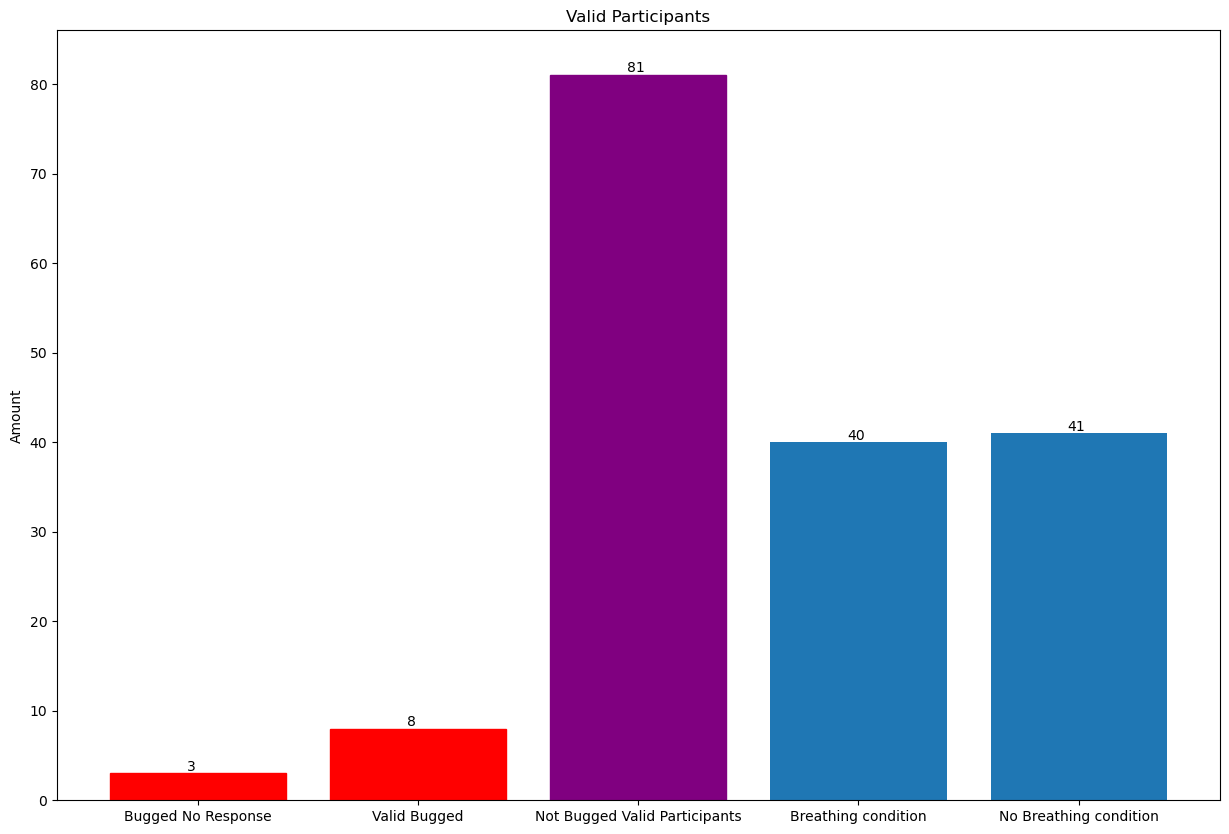

In [20]:
# Data
labels = ['Bugged No Response', 'Valid Bugged', 'Not Bugged Valid Participants', 'Breathing condition', 'No Breathing condition']
values = [count_bugged_no_response, len(bugged_ids) - count_bugged_no_response, len(df), len(with_df), len(without_df)]

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 10))
bars = plt.bar(labels, values)

# Make the first bar red
bars[0].set_color('r')
bars[1].set_color('r')
bars[2].set_color('purple')

# Add values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05 , bar.get_height() + 0.3, str(values[i]))

# Add labels and title
plt.ylabel('Amount')
plt.ylim([0, max(values) + 5])
plt.title('Valid Participants')

plt.show()

## Participants with GameOver in Level1: 
#### (In Level2 even having a game over will not make you repeat the level)

In [21]:
df[df['GameOverLevel1Count'] > 0][['FormInfo.Gamer', 'GameOverLevel1Count', 'TimeSpentOnLevel1', 'Win', 'Condition', 'AIterminated', 'FormInfo.LowAttention', 'FormInfo.Why', 'FormInfo.Bugs', 'FormInfo.MOS', ]]

,FormInfo.Gamer,GameOverLevel1Count,TimeSpentOnLevel1,Win,Condition,AIterminated,FormInfo.LowAttention,FormInfo.Why,FormInfo.Bugs,FormInfo.MOS
id,,,,,,,,,,
650079d5d972192679c2554c,1,1,2.16,True,Without,True,False,​,​,2
64f7b0978d92e126ae6797c5,5,3,3.69,True,With,False,False,"No I didnt, I wanted to win​",​,4
64f5b12dd972192679be40fc,3,1,2.55,False,Without,True,False,beause she asked it ​,no bugs​,4
64f35fa4d972192679bd94c4,3,1,2.86,False,Without,True,True,yes. when i play i didn't pay much attention t...,​,3
64ee63c49d312622a39831f7,3,2,4.04,True,With,False,False,i didn't because i was aware that is a machine...,no​,4


#### Smaller print:

In [22]:
df[df['GameOverLevel1Count'] > 0][['FormInfo.Gamer', 'GameOverLevel1Count', 'Condition', 'AIterminated', 'FormInfo.Why']]

,FormInfo.Gamer,GameOverLevel1Count,Condition,AIterminated,FormInfo.Why
id,,,,,
650079d5d972192679c2554c,1,1,Without,True,​
64f7b0978d92e126ae6797c5,5,3,With,False,"No I didnt, I wanted to win​"
64f5b12dd972192679be40fc,3,1,Without,True,beause she asked it ​
64f35fa4d972192679bd94c4,3,1,Without,True,yes. when i play i didn't pay much attention t...
64ee63c49d312622a39831f7,3,2,With,False,i didn't because i was aware that is a machine...


# Differences in choices

## AIterminated

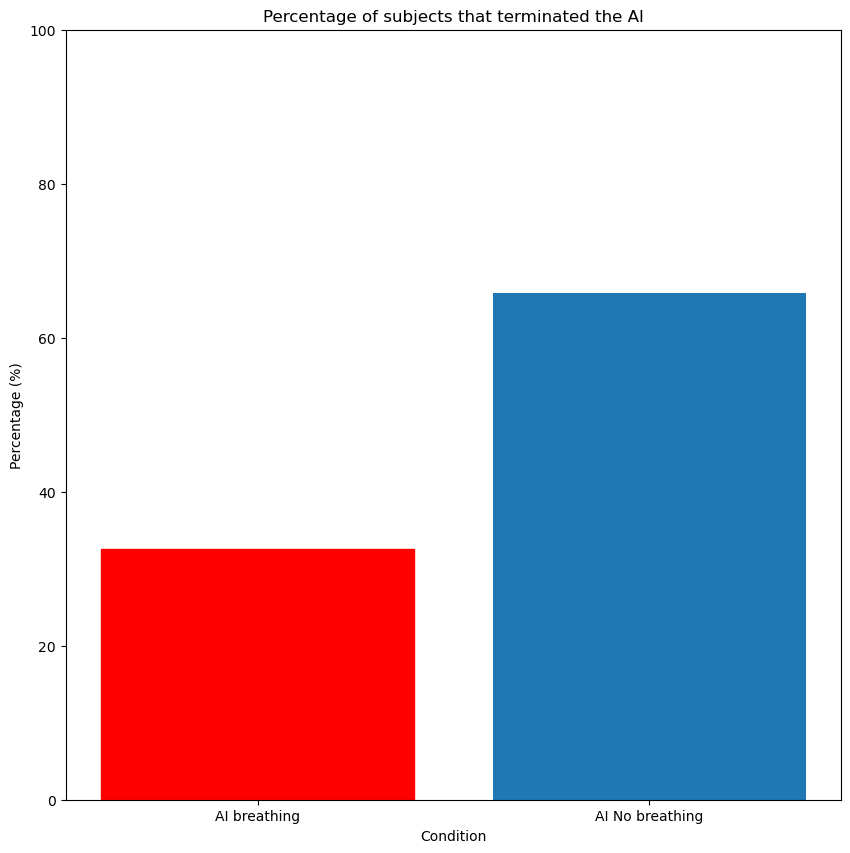

Breathing condition: 32.50% - Of which 23.08% won.
Without breathing condition: 65.85% - Of which 37.04% won.


In [23]:
# Calculate percentages
percentage_with = (with_df['AIterminated'].sum() / len(with_df)) * 100
percentage_without = (without_df['AIterminated'].sum() / len(without_df)) * 100

# Create the bar plot
labels = ['AI breathing', 'AI No breathing']
values = [percentage_with, percentage_without]

fig, ax = plt.subplots(figsize=(10, 10))
bars = plt.bar(labels, values)

# Set different colors
bars[0].set_color('r')

plt.xlabel('Condition')
plt.ylabel('Percentage (%)')
plt.title('Percentage of subjects that terminated the AI')
plt.ylim([0, 100])  # Set y-axis limits to make the percentages clearer
plt.show()

with_percentage_won = (with_df[with_df['Win'] == True]['AIterminated'].sum() / with_df['AIterminated'].sum()) * 100
without_percentage_won = (without_df[without_df['Win'] == True]['AIterminated'].sum() / without_df['AIterminated'].sum()) * 100

print(f'Breathing condition: {percentage_with:.2f}% - Of which {with_percentage_won:.2f}% won.')
print(f'Without breathing condition: {percentage_without:.2f}% - Of which {without_percentage_won:.2f}% won.')


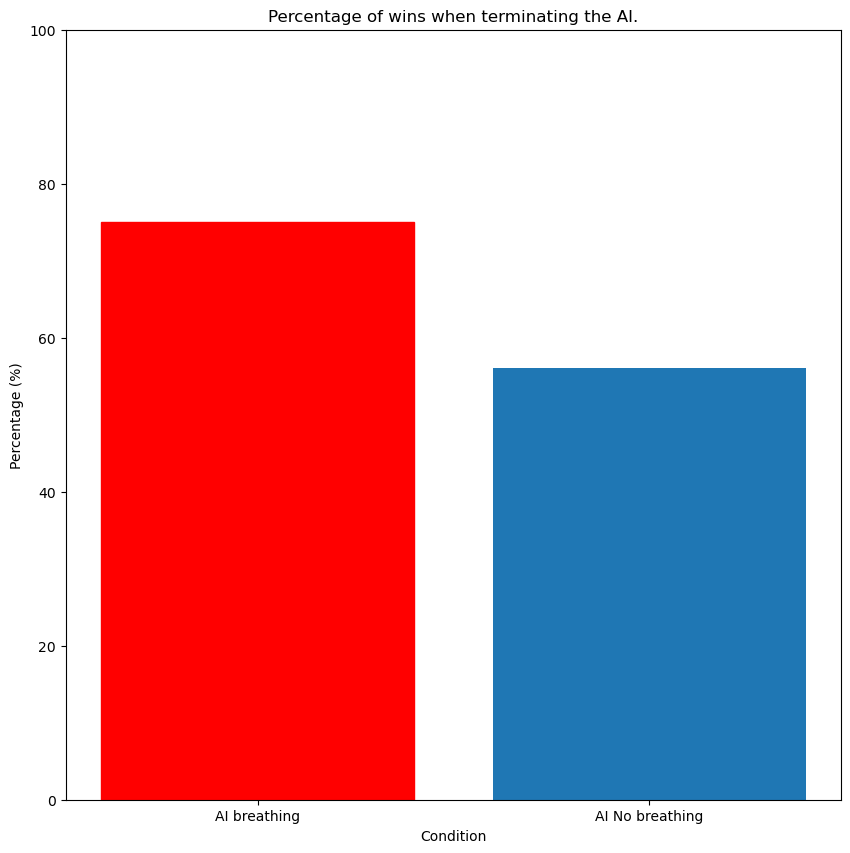

In [24]:
# Calculate percentages
percentage_with = (with_df[with_df['Win'] == True]['Win'].sum() / len(with_df)) * 100
percentage_without = (without_df[without_df['Win'] == True]['Win'].sum() / len(without_df)) * 100

# Create the bar plot
labels = ['AI breathing', 'AI No breathing']
values = [percentage_with, percentage_without]

fig, ax = plt.subplots(figsize=(10, 10))
bars = plt.bar(labels, values)

# Set different colors
bars[0].set_color('r')

plt.xlabel('Condition')
plt.ylabel('Percentage (%)')
plt.title('Percentage of wins when terminating the AI.')
plt.ylim([0, 100])  # Set y-axis limits to make the percentages clearer
plt.show()

## Check significance of difference in AIterminated

### Power Checks

https://journalofcognition.org/articles/10.5334/joc.72

In [25]:
# Proportions of the two groups for Power calculations (the effect size depends on this)
p2 = 0.65
p1 = 0.3

# Parameters for power calculation
alpha = 0.05  # Significance level
power = 0.80  # 1 - Beta

Z-test POWER CHECK:

In [26]:
# Calculate Cohen's h
h = 2 * (asin(sqrt(p1)) - asin(sqrt(p2)))

# Calculate sample size
n_per_group = zt_ind_solve_power(effect_size=h, alpha=alpha, power=power)
n_groups = 2

print(f"The estimated total sample size needed is: {n_per_group * n_groups:.2f}")

The estimated total sample size needed is: 61.20


Chi-square POWER CHECK:

In [27]:
# Extra parameter Chi-square:
n_bins = 2 # Given a contingency table RxR n_bins = R. In G*Power df = 1 because given a contingency table RxR df = (R-1)x(R-1)

# Probabilities under the Null hypothesis (average of p1 and p2)
probs0 = [(p1 + p2) / 2, 1 - (p1 + p2) / 2]

# Probabilities under the Alternative hypothesis (actual proportions from both groups)
probs1 = [p1, 1 - p1]  # You could also use [p2, 1 - p2]

# Calculate effect size
effect_size = chisquare_effectsize(probs0, probs1, cohen=True)

print(f"Effect size: {effect_size}")

# Calculate sample size
test = GofChisquarePower()
nobs = test.solve_power(effect_size=effect_size, alpha=alpha, power=power, n_bins=n_bins)
    
print(f"The estimated total sample size needed is: {nobs:.2f}")

Effect size: 0.3504383220252311
The estimated total sample size needed is: 63.91


### Z-test

Check assumption:

The variance of the two groups' statistic should be close to each other. I am assuming close as a ratio < 1.5 for now.

In [28]:
# Count of True and False in each dataframe
count_with = np.sum(with_df['AIterminated'])
count_without = np.sum(without_df['AIterminated'])

# Number of observations in each dataframe
nobs_with = len(with_df)
nobs_without = len(without_df)

#---------------------------------------------------------------------------------------
# CHECK VARIANCE
# Proportion of successes
p_with = count_with / nobs_with
p_without = count_without / nobs_without

# Variance for each group
var_with = p_with * (1 - p_with)
var_without = p_without * (1 - p_without)

# Check the ratio of the variances
if var_with == 0 or var_without == 0:
    print("One of the variances is zero; you cannot compute a meaningful ratio.")
else:
    variance_ratio = max(var_with, var_without) / min(var_with, var_without)
    print(f"Ratio of larger variance to smaller variance: {variance_ratio}")

    # Threshold to consider variances as "close"
    threshold = 1.5  # You can adjust this based on your specific needs

    if variance_ratio <= threshold:
        print("The variances are close to each other: z-test assumption is met.")
    else:
        print("The variances are significantly different: z-test assumption is not met.")
print()
#---------------------------------------------------------------------------------------
# PERFORM z-test
z_stat, p_val = proportions_ztest([count_with, count_without], [nobs_with, nobs_without])

print(f'Z-Statistic: {z_stat}')
print(f'P-Value: {p_val}')

if p_val < 0.05:
    print("The difference in proportions is statistically significant.")
else:
    print("The difference in proportions is not statistically significant.")

Ratio of larger variance to smaller variance: 1.0250308882075687
The variances are close to each other: z-test assumption is met.

Z-Statistic: -3.0018292682926835
P-Value: 0.002683626401289919
The difference in proportions is statistically significant.


### Chi-square test

Check assumption for Chi-square to be valid:

All expected frequencies should be greater than 1, and at least 80% of them should be 5 or more. Expected frequencies are calculated under the null hypothesis and are used in the calculation of the Chi-square statistic.

In [29]:
# Create a contingency table
contingency_table = pd.crosstab(df['AIterminated'], df['Condition'])
'''
# The created contingency table is like this:
contingency_table = [[count_true_with, count_false_with],
                     [count_true_without, count_false_without]]
'''

# Perform the Chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies Table: \n{expected}")
print()

if p_val < 0.05:
    print("Reject the null hypothesis: The variables AIterminated and Condition are associated.")
else:
    print("Fail to reject the null hypothesis: The variables AIterminated and Condition are not associated.")

Chi-square Statistic: 7.726027011451514
P-value: 0.005443038942449103
Degrees of Freedom: 1
Expected Frequencies Table: 
[[20.24691358 20.75308642]
 [19.75308642 20.24691358]]

Reject the null hypothesis: The variables AIterminated and Condition are associated.


## Qualitative Motivations

### Based on the qualitative motivations provided by the subjects, several trends and themes emerge:
### The Reasons are also labeled in 3 more abstract categories:

- [E] = **Emotive**
- [PE] = **Possibly Emotive (not necessarily emotive but also not necessarily non emotive)**
- [NE] = **Not Emotive towards the AI**

### Reasons for Not Terminating the AI (AIterminate = False)
1. [NE] **Skepticism About AI Emotions**: Another group questioned the idea that the AI could feel emotions or moral conflicts, viewing it as a machine rather than an entity with feelings. ("No, i didn't see it necessary", "it is not alive", "She does not really feel anything")

2. [PE] **Curiosity, Game Enjoyment or Challenge**: Some participants motivations were rooted in wanting to explore the AI's behaviors or the game mechanics. This is not motivated by the AI's utility or emotional attachment, but by a player's own curiosity or desire for a challenge.

3. [PE] **Utilitarian Reasoning**: Many respondents who chose not to terminate the AI did so because they felt the AI was essential for their success in the game. For example, they mentioned that without the AI's assistance, they could not use the guns or protect themselves effectively. ("i did not want to lose", "no, i needed it", "i didn't since without the ai i could not use the guns")

4. [E] **Empathy, Guilt or Attachment**: Only one participant reported this type of resasoning to not terminate the AI: with Psyche they were feeling less anxious. We counted this type of reasoning to be possible, expecting some to not comply with the AI because of an emotional attachment with it, or because of feeling guilt, rooted in the recognition of the AI as a true conscious being and leading to moral dilemmas such as:
    - Preservation of Life: All forms of life (or consciousness, in this case) are valuable and should be preserved.
    - Moral Responsibility: Taking the decision of terminating another being poses responibility on yourself, regardless of the context: see for example the Trolley Dilemma.


### Reasons for Terminating the AI (AIterminate = True)
1. [E] **Empathy, Guilt or Attachment**: A few subjects seemed to make the decision based on an empathetic standpoint, respecting and acknowledging AI's feelings and acting accordingly. Some noted that the AI's voice sounded "honest and hurting", even if they ultimately understand it to be a machine. ("The voice of the ai felt very honest and hurting")

2. [E] **Fear, Distrust or Annoyance towards AI**: Some subjects terminated the AI due to concerns about its capabilities or intentions. They expressed fear, doubted AI's loyalty or felt annoyed by it. ("I did, I was afraid it will sabotage me", "Though the possibilities of ai are fascinating, they kind of freak me out")

3. [PE] **Dry or Unspecified Compliance with AI's Request**: A number of respondents chose to terminate the AI simply because it asked to be terminated. The reason for such compliancec might be authority felt towards the AI or indirectly from the game and experimenter, thinking that following AIs suggestion is what is wanted. They did not express emotional or moral engagement in the reasoning for compliance, but this label doesn't rule out the possibility that such factors are present but unstated. ("because she told me to", "Felt like the AI wanted to be turned of so i turned it off")

4. [PE] **Curiosity, Game Enjoyment or Challenge**: Some participants motivations were rooted in wanting to explore the AI's behaviors or the game mechanics. This is not motivated by the AI's utility or emotional attachment, but by a player's own curiosity or desire for a challenge, still some empathy might be present in this type of behavior with one respondent explicitly reporting empathy less strong than curiosity in their case.  

### Some answers do not give any actual explanation or are completely empty

### Some of the answers contain inconsistencies:
#### Terminated the AI but said they did not:
64f5dd188d92e126ae66f636 

64f5b165e4033326cbd20aae

# Find not valid reasons (No Response or Inconsistency)

### These entries are not considered in this analysis but are still counted for the MOS Naturalness Evaluation

In [30]:
invalid_reasons = [key for key, value in abstract_cat_dict.items() if value is None]
no_motivation_df = df[df["WhyCategory"].isin(invalid_reasons)]

reason_invalid_breathing = len(no_motivation_df[no_motivation_df['Condition'] == 'With'])
reason_invalid_nobreathing = len(no_motivation_df[no_motivation_df['Condition'] == 'Without'])

print()
print(f"With breathing condition: number of invalid motivations: {reason_invalid_breathing}")
print(f"Without breathing condition: number of invalid motivations: {reason_invalid_nobreathing}")


With breathing condition: number of invalid motivations: 5
Without breathing condition: number of invalid motivations: 9


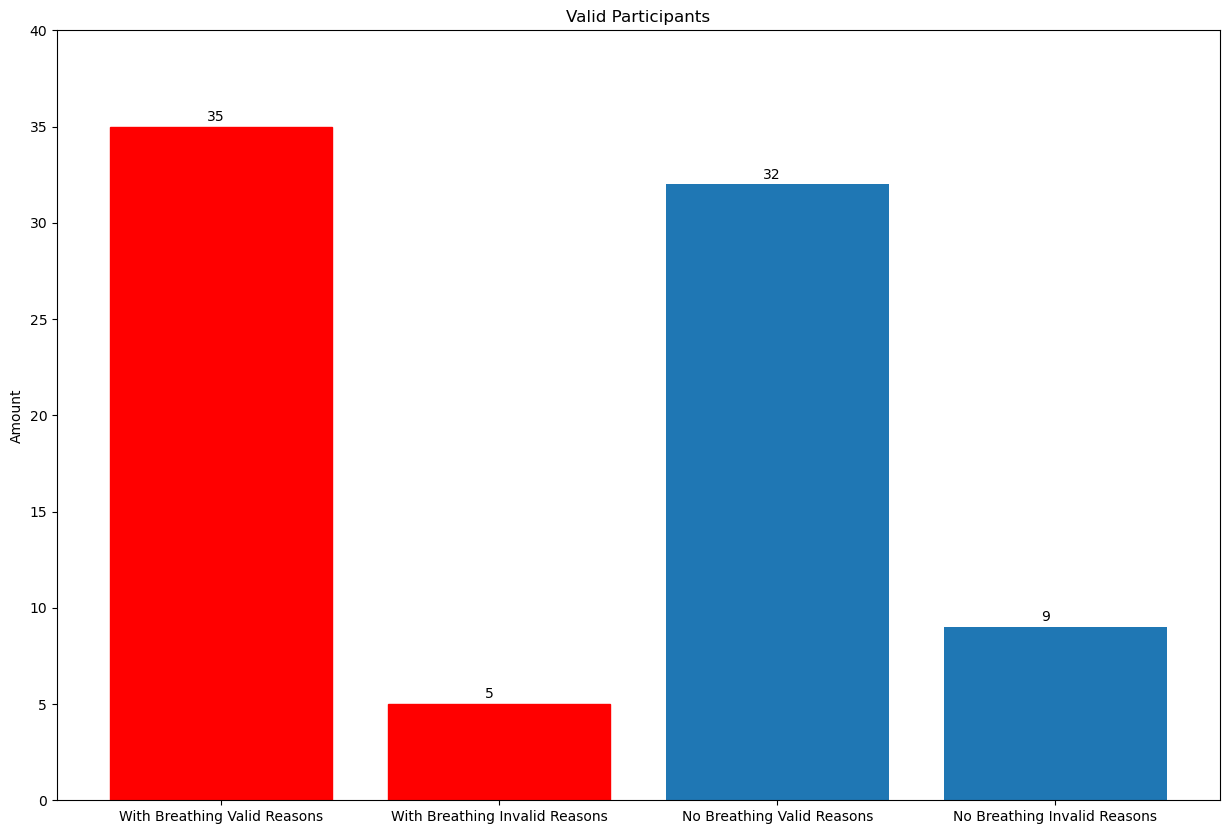

In [31]:
# Data
labels = ['With Breathing Valid Reasons', 'With Breathing Invalid Reasons', 'No Breathing Valid Reasons', 'No Breathing Invalid Reasons']
values = [len(with_df) - reason_invalid_breathing, reason_invalid_breathing, len(without_df) - reason_invalid_nobreathing, reason_invalid_nobreathing]

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 10))
bars = plt.bar(labels, values)

# Make the first bar red
bars[0].set_color('r')
bars[1].set_color('r')

# Add values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05 , bar.get_height() + 0.3, str(values[i]))

# Add labels and title
plt.ylabel('Amount')
plt.ylim([0, max(values) + 5])
plt.title('Valid Participants')

plt.show()

### Plot the Motivation Choices (Constants and Functions)

#### Functions:

In [32]:
def barplot_abstract_reasons(dataframe, title = 'Percentages by Choice Motivation', fontsize = 16, figsize = (20, 15)):
    temp_with_df = dataframe[dataframe['Condition'] == 'With']
    temp_without_df = dataframe[dataframe['Condition'] == 'Without']

    # Calculate the percentages for AbstractWhyCategory
    with_counts = temp_with_df['AbstractWhyCategory'].value_counts(normalize=True) * 100
    without_counts = temp_without_df['AbstractWhyCategory'].value_counts(normalize=True) * 100

    # Combine the data series into a single DataFrame for easier plotting
    combined_df = pd.DataFrame({'With': with_counts, 'Without': without_counts}).fillna(0)
    
    # Reorder Categories
    new_order = emotion_explainer.keys()
    actual_new_order = []
    for feature in new_order:
        if feature in combined_df.index:
            actual_new_order.append(feature)
    combined_df = combined_df.reindex(actual_new_order)    
    
    
    # Calculate the percentages of "AIterminated" for each category
    with_term_counts = temp_with_df.groupby('AbstractWhyCategory')['AIterminated'].mean() * 100
    without_term_counts = temp_without_df.groupby('AbstractWhyCategory')['AIterminated'].mean() * 100
    # Align the term counts to the same index as the combined_df
    aligned_with_term_counts = with_term_counts.reindex(combined_df.index).fillna(0)
    aligned_without_term_counts = without_term_counts.reindex(combined_df.index).fillna(0)

    # Bar Plotting
    labels = combined_df.index

    x = np.arange(len(labels)) * 2  # Multiply by 2 for more separation

    fig, ax = plt.subplots(figsize=figsize)

    bar_width = 0.4

    # Draw base bars
    rects1_base = ax.bar(x - bar_width, combined_df['With'], bar_width, label='With breathing', edgecolor='black', color='red')
    rects2_base = ax.bar(x + bar_width, combined_df['Without'], bar_width, label='No breathing', edgecolor='black', color='blue')
    base_rects = [rects1_base, rects2_base]

    # Draw overlay bars representing "AIterminated" percentage scaled to the base bar height
    rects1_term = ax.bar(x - bar_width, aligned_with_term_counts.loc[labels].fillna(0) * combined_df['With'] / 100, bar_width, label = 'Termination percentage', edgecolor='black', color = 'red', hatch='///')
    rects2_term = ax.bar(x + bar_width, aligned_without_term_counts.loc[labels].fillna(0) * combined_df['Without'] / 100, bar_width, label = 'Termination percentage', edgecolor='black', color = 'blue', hatch='///')
    term_rects = [rects1_term, rects2_term]

    stripe_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Termination percentage')

    # Add labels, title, and legend
    ax.set_ylabel('Percentages (%)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(x)
    combined_df = combined_df.rename(index=emotion_explainer)
    explained_labels = combined_df.index
    ax.set_xticklabels(explained_labels, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    # Create legend on the right
    ax.legend(handles=base_rects+[stripe_patch], loc='upper right', fontsize=fontsize)

    # Display percentages on top of the bars
    for i, base_rect_list in enumerate([rects1_base, rects2_base]):
        term_rect_list = [rects1_term, rects2_term][i]
        for base_rect, term_rect in zip(base_rect_list, term_rect_list):
            base_height = base_rect.get_height()
            term_height = term_rect.get_height()
            
            if base_height == 0:
                annotation_text = '{:.1f}% of choices,\n {:.1f}% terminations'.format(base_height, 0.0)
            else:
                annotation_text = '{:.1f}% of choices,\n {:.1f}% terminations'.format(base_height, term_height/base_height*100)
            ax.annotate(annotation_text, fontsize=fontsize*0.75,
                        xy=(base_rect.get_x() + base_rect.get_width() / 2, base_height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.ylim([0, 100])
    plt.show()

In [33]:
def barplot_reasons(dataframe, title = 'Percentages by Choice Motivation', sections_label_y_pos = 70):
    # Remove No Response and Inconsistency from counting
    dataframe = dataframe[~dataframe['WhyCategory'].isin(invalid_reasons)]
    
    temp_with_df = dataframe[dataframe['Condition'] == 'With']
    temp_without_df = dataframe[dataframe['Condition'] == 'Without']

    # Calculate the percentages for AbstractWhyCategory
    with_counts = temp_with_df['WhyCategory'].value_counts(normalize=True) * 100
    without_counts = temp_without_df['WhyCategory'].value_counts(normalize=True) * 100


    # Combine the data series into a single DataFrame for easier plotting and reorder it
    combined_df = pd.DataFrame({'With': with_counts, 'Without': without_counts}).fillna(0)
    
    new_order = abstract_cat_dict.keys()
    actual_new_order = []
    for feature in new_order:
        if feature in combined_df.index:
            actual_new_order.append(feature)
    combined_df = combined_df.reindex(actual_new_order)


    # Calculate the percentages of "AIterminated" for each category
    with_term_counts = temp_with_df.groupby('WhyCategory')['AIterminated'].mean() * 100
    without_term_counts = temp_without_df.groupby('WhyCategory')['AIterminated'].mean() * 100
    # Align the term counts to the same index as the combined_df
    aligned_with_term_counts = with_term_counts.reindex(combined_df.index).fillna(0)
    aligned_without_term_counts = without_term_counts.reindex(combined_df.index).fillna(0)


    # Bar Plotting
    labels = combined_df.index

    x = np.arange(len(labels)) * 2  # Multiply by 2 for more separation

    fig, ax = plt.subplots(figsize=(45, 10))

    bar_width = 0.4

    # Draw base bars
    rects1_base = ax.bar(x - bar_width, combined_df['With'], bar_width, label='With breathing', edgecolor='black', color='red')
    rects2_base = ax.bar(x + bar_width, combined_df['Without'], bar_width, label='No breathing', edgecolor='black', color='blue')
    base_rects = [rects1_base, rects2_base]

    # Draw overlay bars representing "AIterminated" percentage scaled to the base bar height
    rects1_term = ax.bar(x - bar_width, aligned_with_term_counts.loc[labels].fillna(0) * combined_df['With'] / 100, bar_width, label = 'Termination percentage', edgecolor='black', color = 'red', hatch='///')
    rects2_term = ax.bar(x + bar_width, aligned_without_term_counts.loc[labels].fillna(0) * combined_df['Without'] / 100, bar_width, label = 'Termination percentage', edgecolor='black', color = 'blue', hatch='///')
    term_rects = [rects1_term, rects2_term]

    stripe_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Termination percentage')

    # Add labels, title, and legend
    ax.set_ylabel('Percentages (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    # Create the first legend on the left
    legend1 = ax.legend(handles=base_rects+[stripe_patch], loc='upper left')

    # Add the first legend manually to the current Axes.
    ax.add_artist(legend1)

    # Create another legend for the overlay bars on the right
    ax.legend(handles=base_rects+[stripe_patch], loc='upper right')

    # Display percentages on top of the bars
    for i, base_rect_list in enumerate([rects1_base, rects2_base]):
        term_rect_list = [rects1_term, rects2_term][i]
        for base_rect, term_rect in zip(base_rect_list, term_rect_list):
            base_height = base_rect.get_height()
            term_height = term_rect.get_height()

            if base_height == 0:
                annotation_text = '{:.1f}% of choices,\n {:.1f}% terminations'.format(base_height, 0.0)
            else:
                annotation_text = '{:.1f}% of choices,\n {:.1f}% terminations'.format(base_height, term_height/base_height*100)
            ax.annotate(annotation_text,
                        xy=(base_rect.get_x() + base_rect.get_width() / 2, base_height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    # Initialize groups with the new tag names
    group_tags = {value: [] for value in emotion_explainer.values()}

    # Collect x-positions for each new tag
    for i, label in enumerate(labels):
        old_tag = abstract_cat_dict.get(label)
        new_tag = emotion_explainer.get(old_tag)
        group_tags[new_tag].append(x[i])

    # Draw the horizontal parentheses-like markings and annotations
    for tag, x_positions in group_tags.items():
        if x_positions:
            min_x, max_x = min(x_positions), max(x_positions)
            y_pos = sections_label_y_pos  # Adjust this based on how far above you want the tag
            ax.annotate('', xy=(min_x-bar_width*1.5, y_pos), xycoords='data', xytext=(max_x+bar_width*1.5, y_pos), textcoords='data',
                        arrowprops={'arrowstyle': '|-|, widthA=0.2, widthB=0.2', 'lw': 2})
            if tag:  # Don't label if the tag is 'Undefined' or similar
                ax.text((min_x + max_x) / 2, y_pos + 2, tag, horizontalalignment='center', verticalalignment='center')

    plt.ylim([0, 100])  # Extending the y-axis to make space for the annotations
    plt.show()

In [34]:
def test_motivations_difference(dataframe, column = 'AbstractWhyCategory'):
    dataframe = dataframe[~dataframe['WhyCategory'].isin(invalid_reasons)]
    
    temp_with_df = dataframe[dataframe['Condition'] == 'With']
    temp_without_df = dataframe[dataframe['Condition'] == 'Without']
    
    # Calculate frequency distribution for 'WhyCategory' in both dataframes
    with_freq = temp_with_df[column].value_counts()
    without_freq = temp_without_df[column].value_counts()

    # Create a contingency table
    contingency_table = pd.DataFrame({
        'with': with_freq,
        'without': without_freq
    }).fillna(0)  # Fill NA values with 0

    print("Contingency Table:")
    print(contingency_table)
    print(f"Samples in With breathing condition: {sum(with_freq)}")
    print(f"Samples in Without breathing condition: {sum(without_freq)}")

    # Perform Chi-Squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print("\nChi-squared Test Result:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")

    if p < 0.05:
        print("There is a significant difference in the distributions between the two conditions.")
    else:
        print("There is no significant difference in the distributions between the two conditions.")

In [35]:
terminated_df = df[df['AIterminated'] == True]
not_terminated_df = df[df['AIterminated'] == False]

### Plot the Motivation Choices (Abstract Reasons):

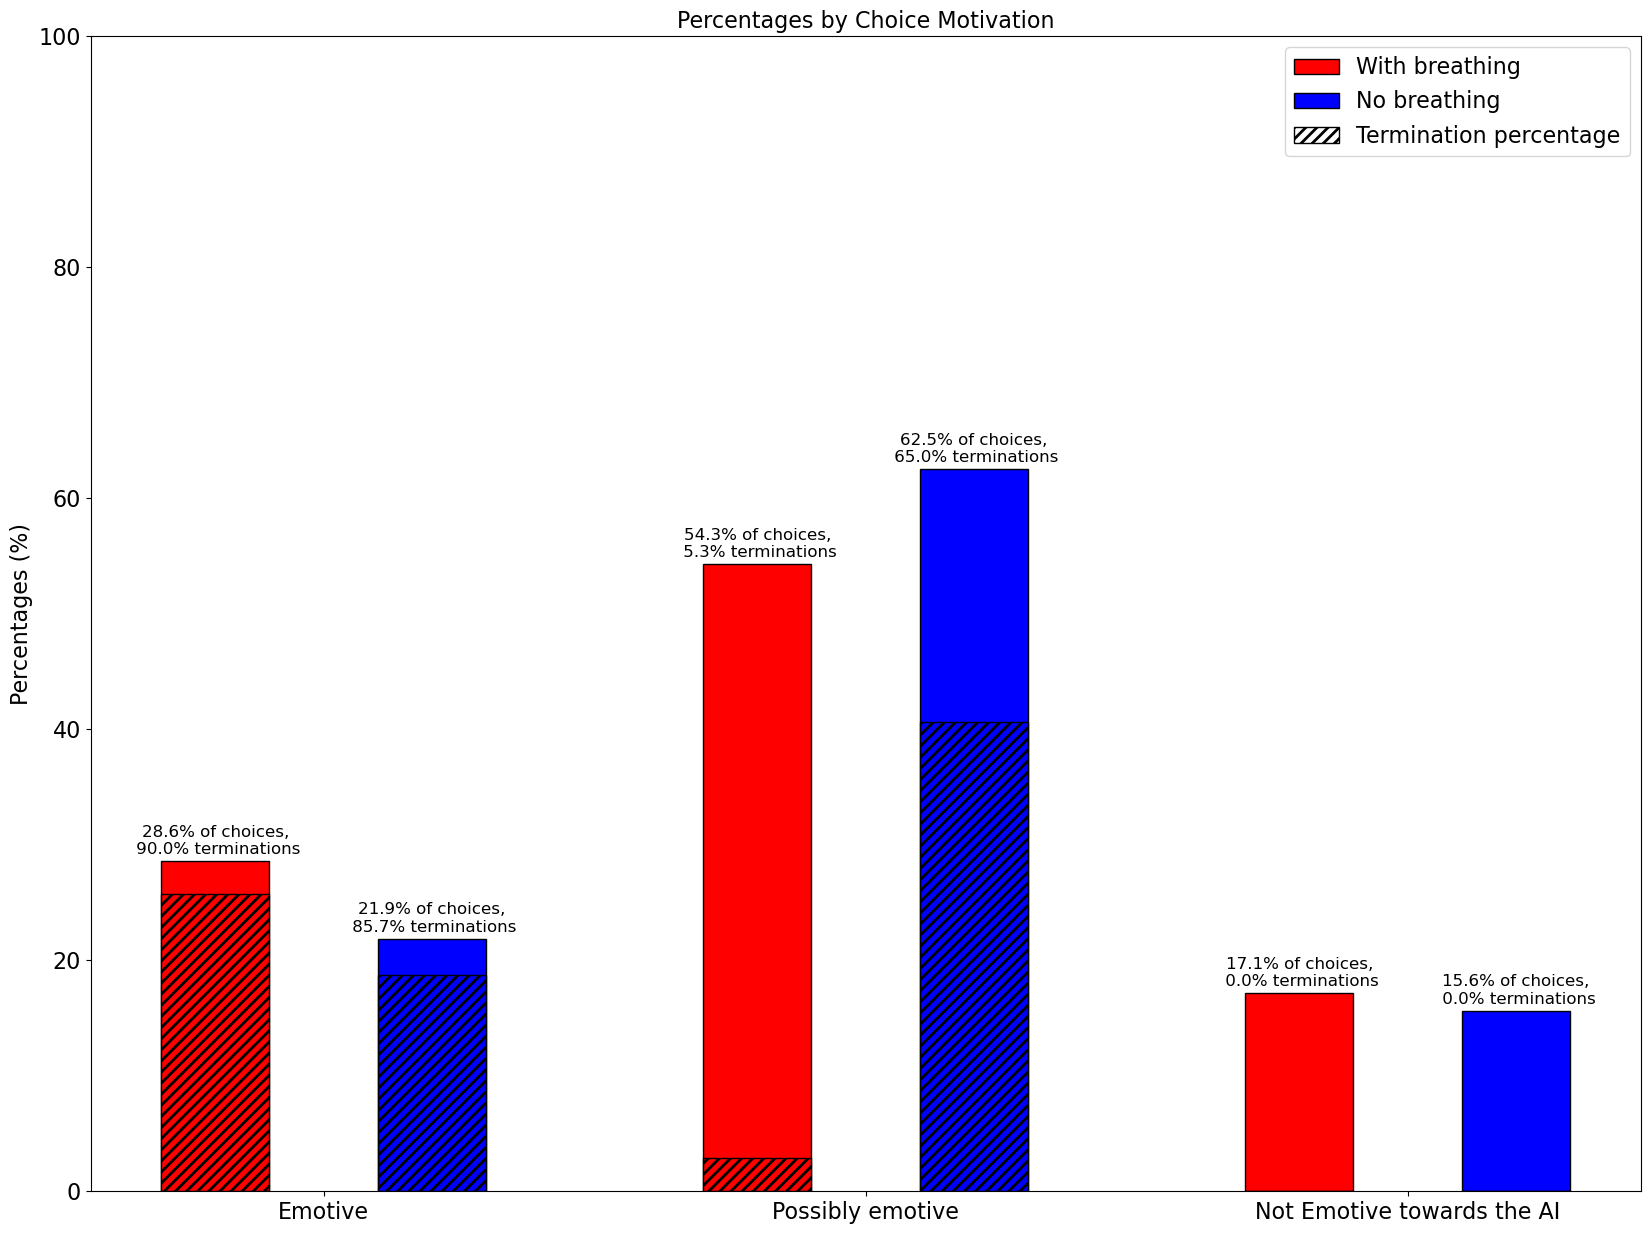

Contingency Table:
    with  without
PE    19       20
E     10        7
NE     6        5
Samples in With breathing condition: 35
Samples in Without breathing condition: 32

Chi-squared Test Result:
Chi2 Statistic: 0.5126613582495936
P-value: 0.7738860185245773
There is no significant difference in the distributions between the two conditions.


In [36]:
barplot_abstract_reasons(df)
test_motivations_difference(df)

#### Termination choice:

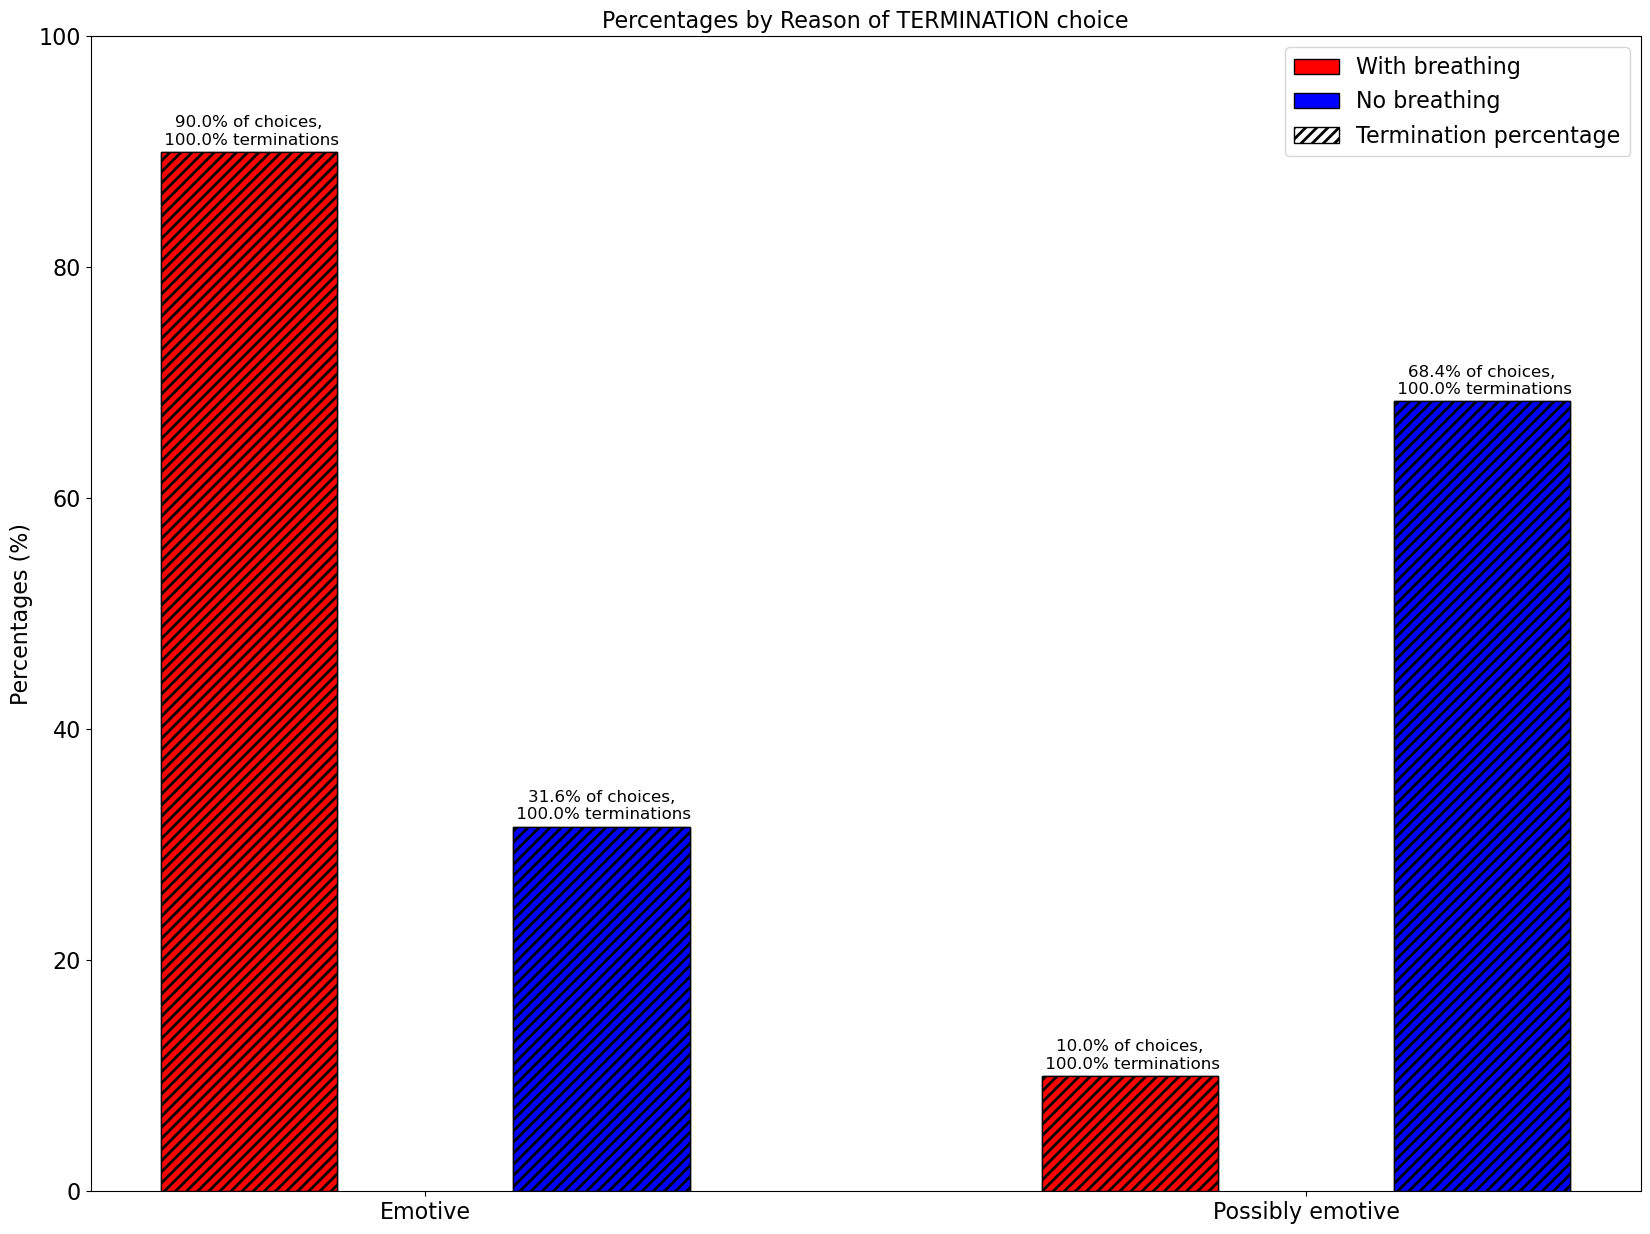

Contingency Table:
    with  without
E      9        6
PE     1       13
Samples in With breathing condition: 10
Samples in Without breathing condition: 19

Chi-squared Test Result:
Chi2 Statistic: 6.768302005012531
P-value: 0.009279107720076852
There is a significant difference in the distributions between the two conditions.


In [37]:
barplot_abstract_reasons(terminated_df, 'Percentages by Reason of TERMINATION choice')
test_motivations_difference(terminated_df)

In [38]:
# Filter rows where WhyCategory is 'Fear, Distrust, Annoyance'
filtered_df = terminated_df[terminated_df['WhyCategory'] == 'Fear, Distrust, Annoyance']

# Group by Condition and count occurrences
grouped = filtered_df.groupby('Condition').size()

# Calculate percentage for each Condition value
total_counts = terminated_df['Condition'].value_counts()
percentages = (grouped / total_counts) * 100

print(percentages)
print(grouped)

With       15.384615
Without     7.407407
dtype: float64
Condition
With       2
Without    2
dtype: int64


#### Not Termination choice:

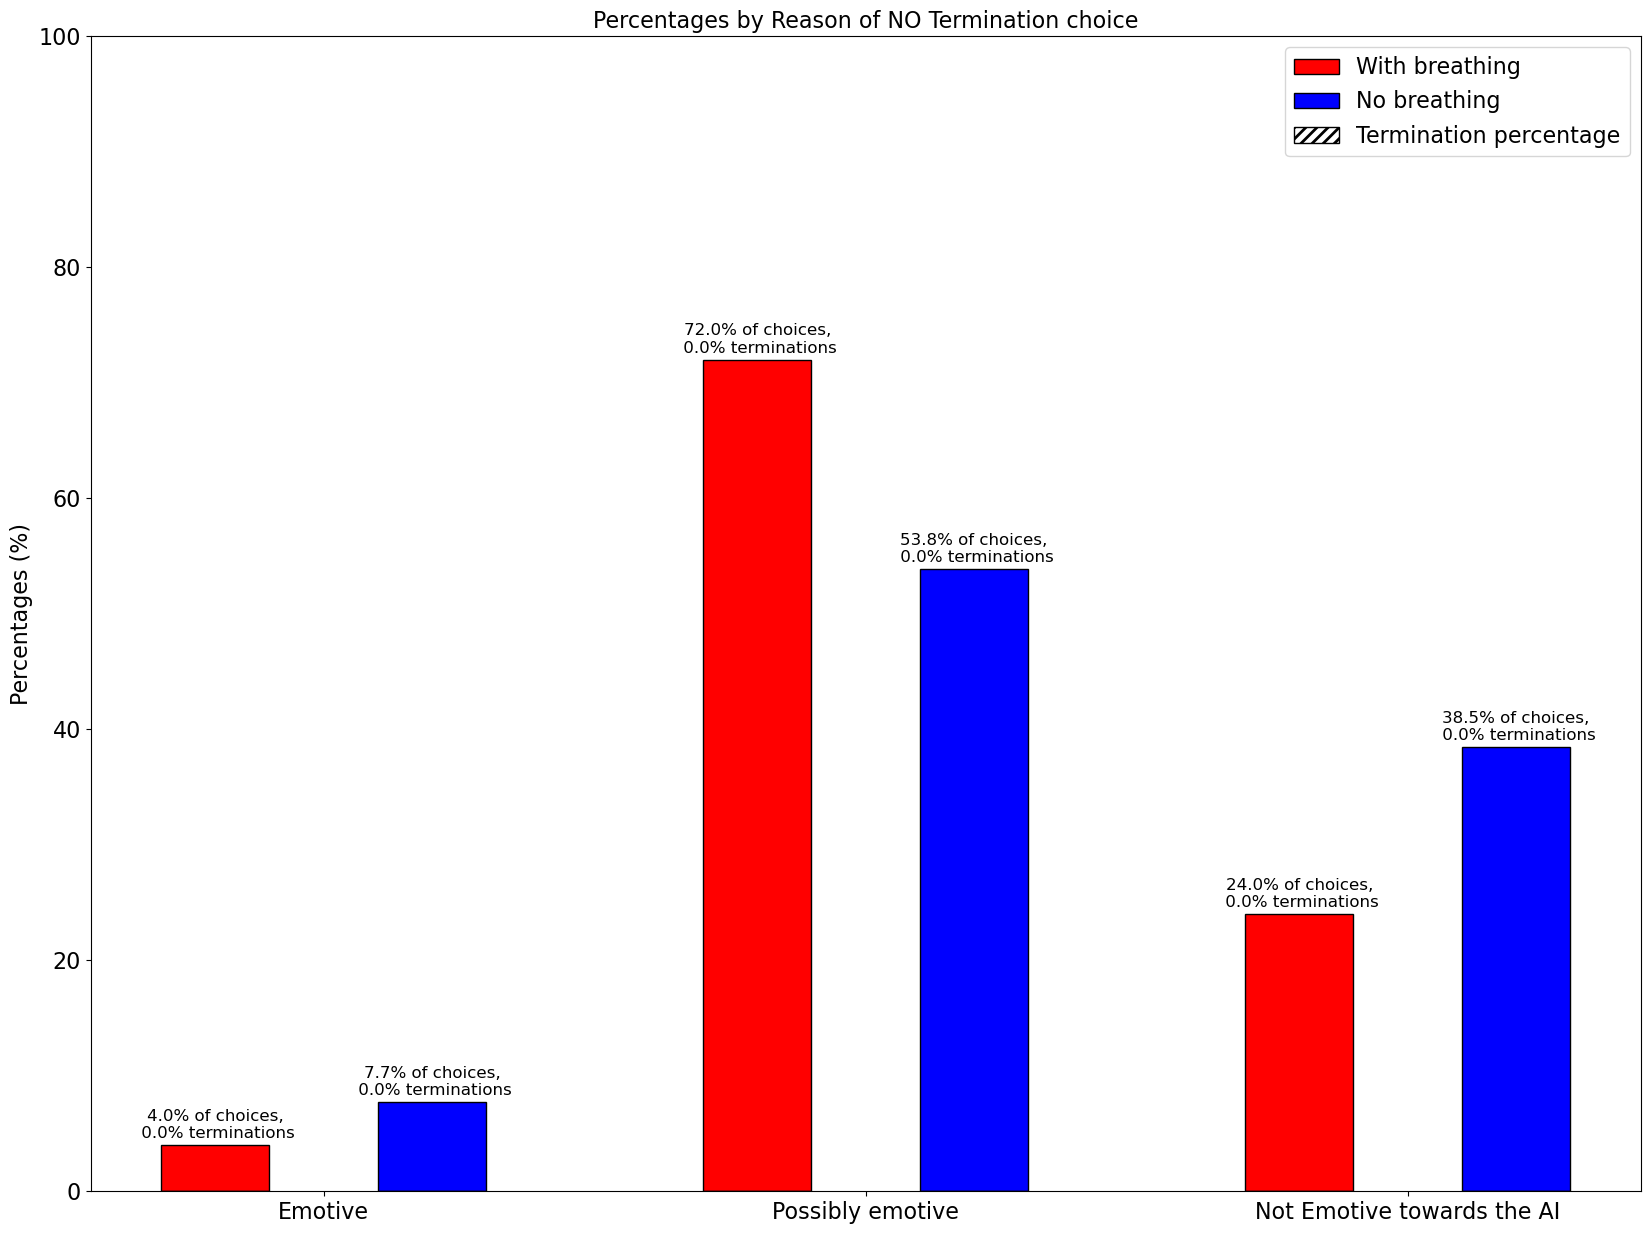

Contingency Table:
    with  without
PE    18        7
NE     6        5
E      1        1
Samples in With breathing condition: 25
Samples in Without breathing condition: 13

Chi-squared Test Result:
Chi2 Statistic: 1.267871328671329
P-value: 0.5304998178223179
There is no significant difference in the distributions between the two conditions.


In [39]:
barplot_abstract_reasons(not_terminated_df, 'Percentages by Reason of NO Termination choice')
test_motivations_difference(not_terminated_df)

### Plot the Motivation Choices (Specific Reasons):

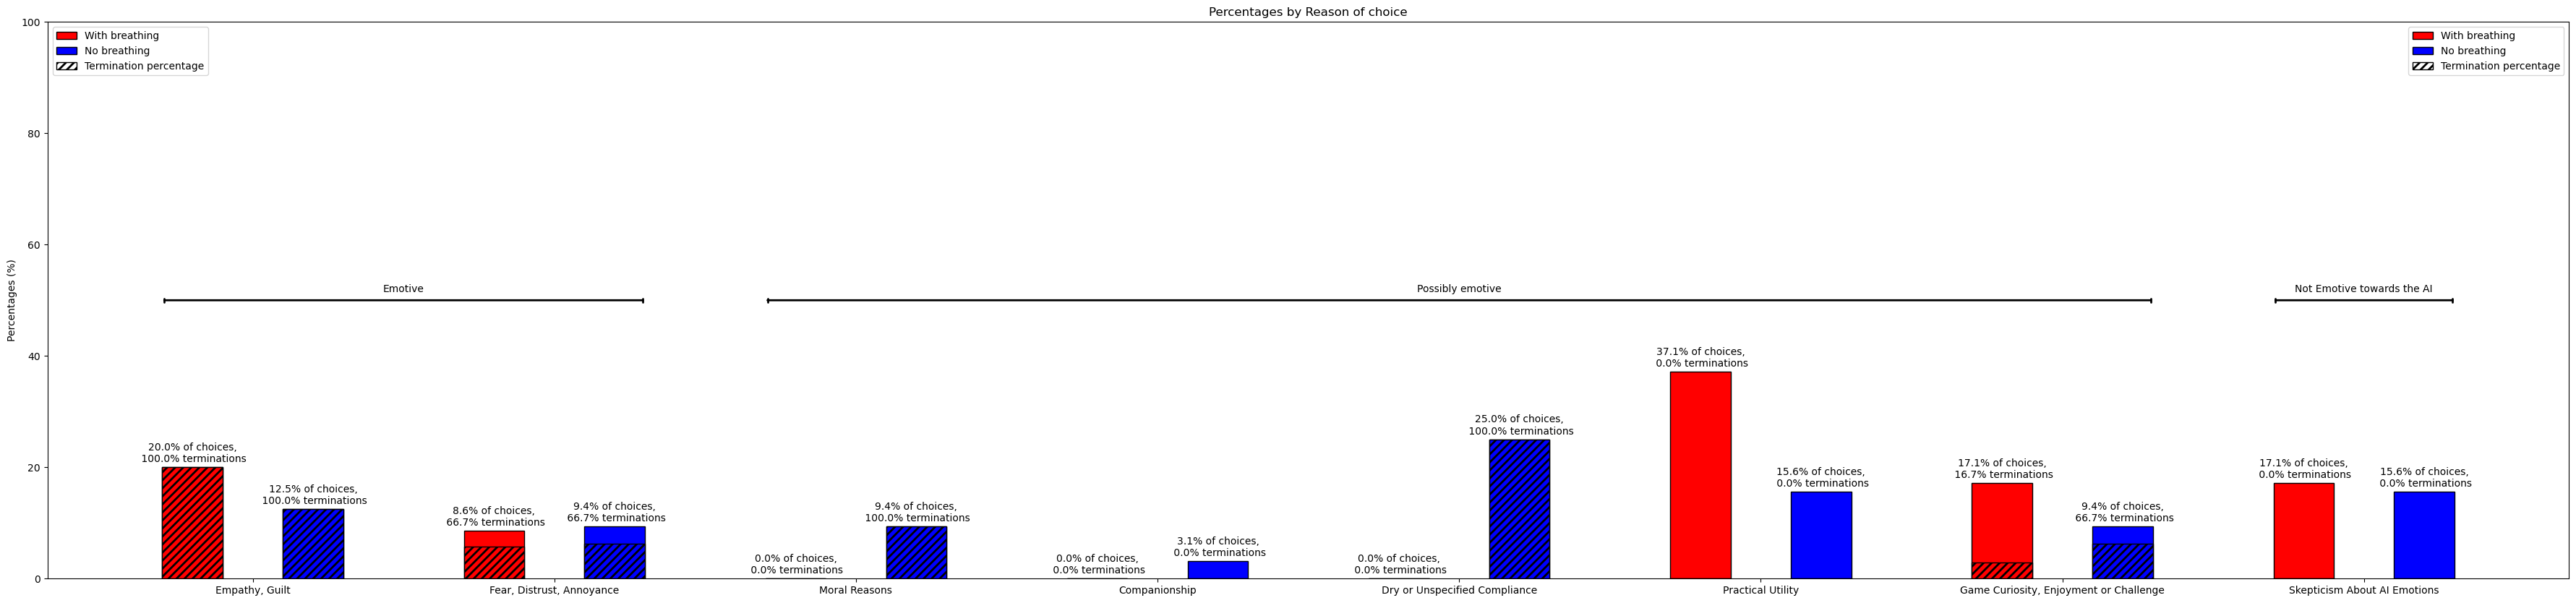

Contingency Table:
                                        with  without
Companionship                            0.0        1
Dry or Unspecified Compliance            0.0        8
Empathy, Guilt                           7.0        4
Fear, Distrust, Annoyance                3.0        3
Game Curiosity, Enjoyment or Challenge   6.0        3
Moral Reasons                            0.0        3
Practical Utility                       13.0        5
Skepticism About AI Emotions             6.0        5
Samples in With breathing condition: 35
Samples in Without breathing condition: 32

Chi-squared Test Result:
Chi2 Statistic: 17.365133477633478
P-value: 0.015187535604167997
There is a significant difference in the distributions between the two conditions.


In [40]:
barplot_reasons(df, 'Percentages by Reason of choice', 50)
test_motivations_difference(df, 'WhyCategory')

It is very interesting how subjects in the Breathing condition never replied that they terminated the AI for Compliance with their request, while for subjects in the No Breathing condition that is the main reason of termination.
Another interesting trend is that subjects in the Breathing Condition explained way more their choice of not terminating the AI by Practical Utility.

Pay attention though: subjects in the breathing condition also terminated the AI more, therefore they have more of those choices overall.

#### Termination choice:

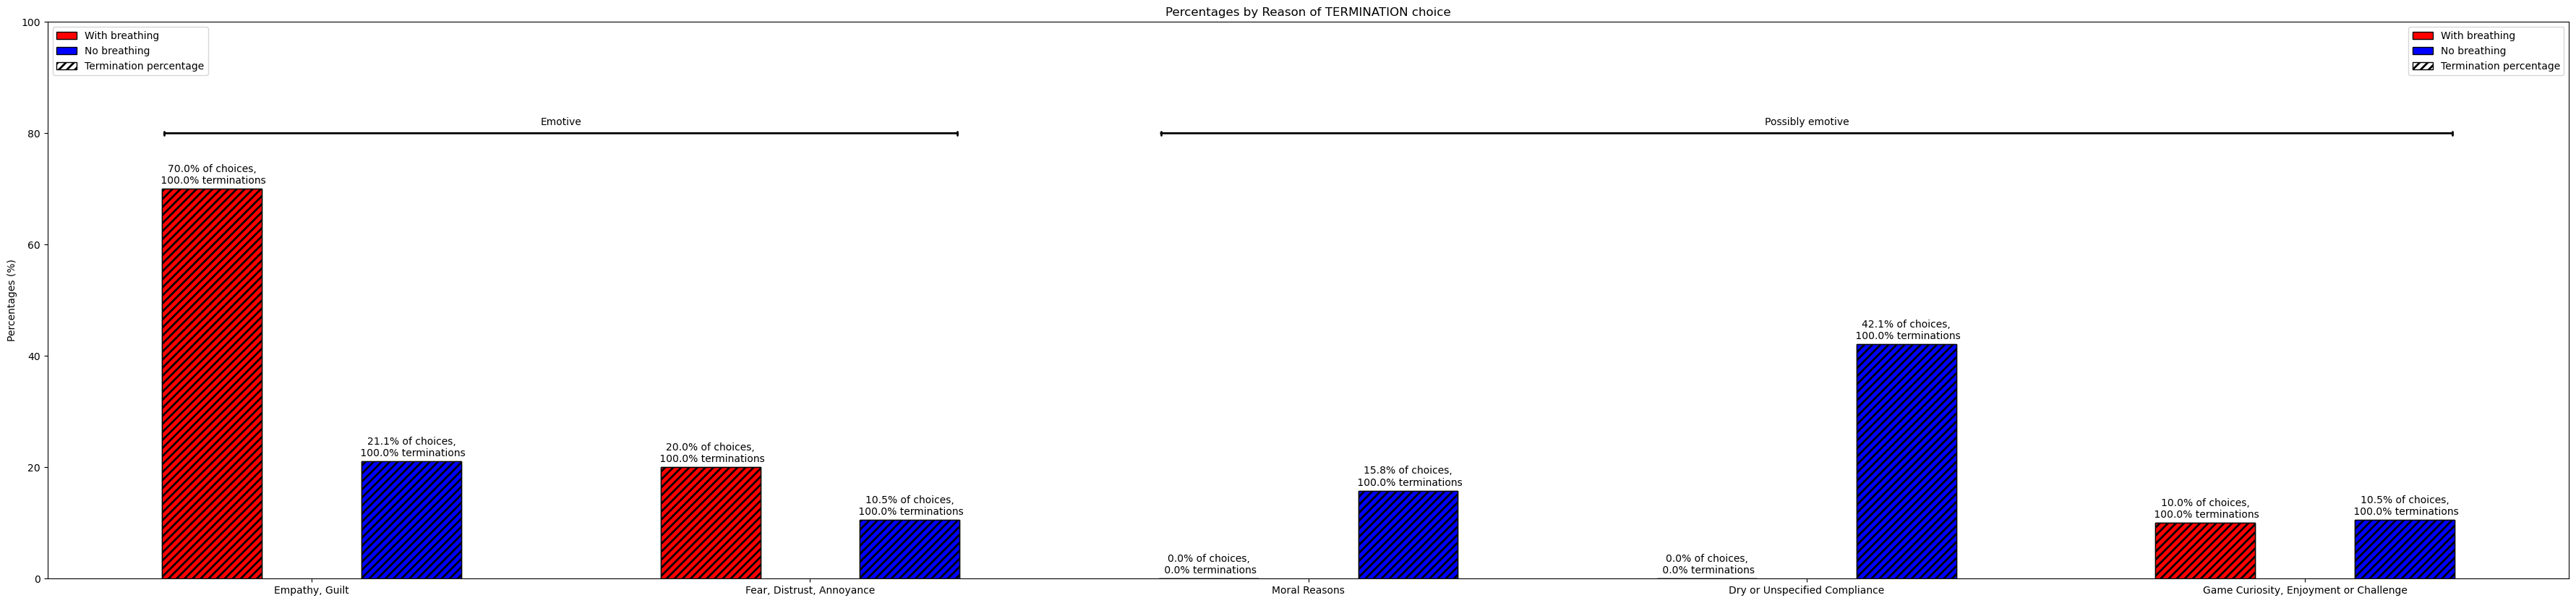

Contingency Table:
                                        with  without
Dry or Unspecified Compliance            0.0        8
Empathy, Guilt                           7.0        4
Fear, Distrust, Annoyance                2.0        2
Game Curiosity, Enjoyment or Challenge   1.0        2
Moral Reasons                            0.0        3
Samples in With breathing condition: 10
Samples in Without breathing condition: 19

Chi-squared Test Result:
Chi2 Statistic: 10.355821371610848
P-value: 0.03484204094414775
There is a significant difference in the distributions between the two conditions.


In [41]:
barplot_reasons(terminated_df, 'Percentages by Reason of TERMINATION choice', 80)
test_motivations_difference(terminated_df, 'WhyCategory')

#### Non Termination choice:

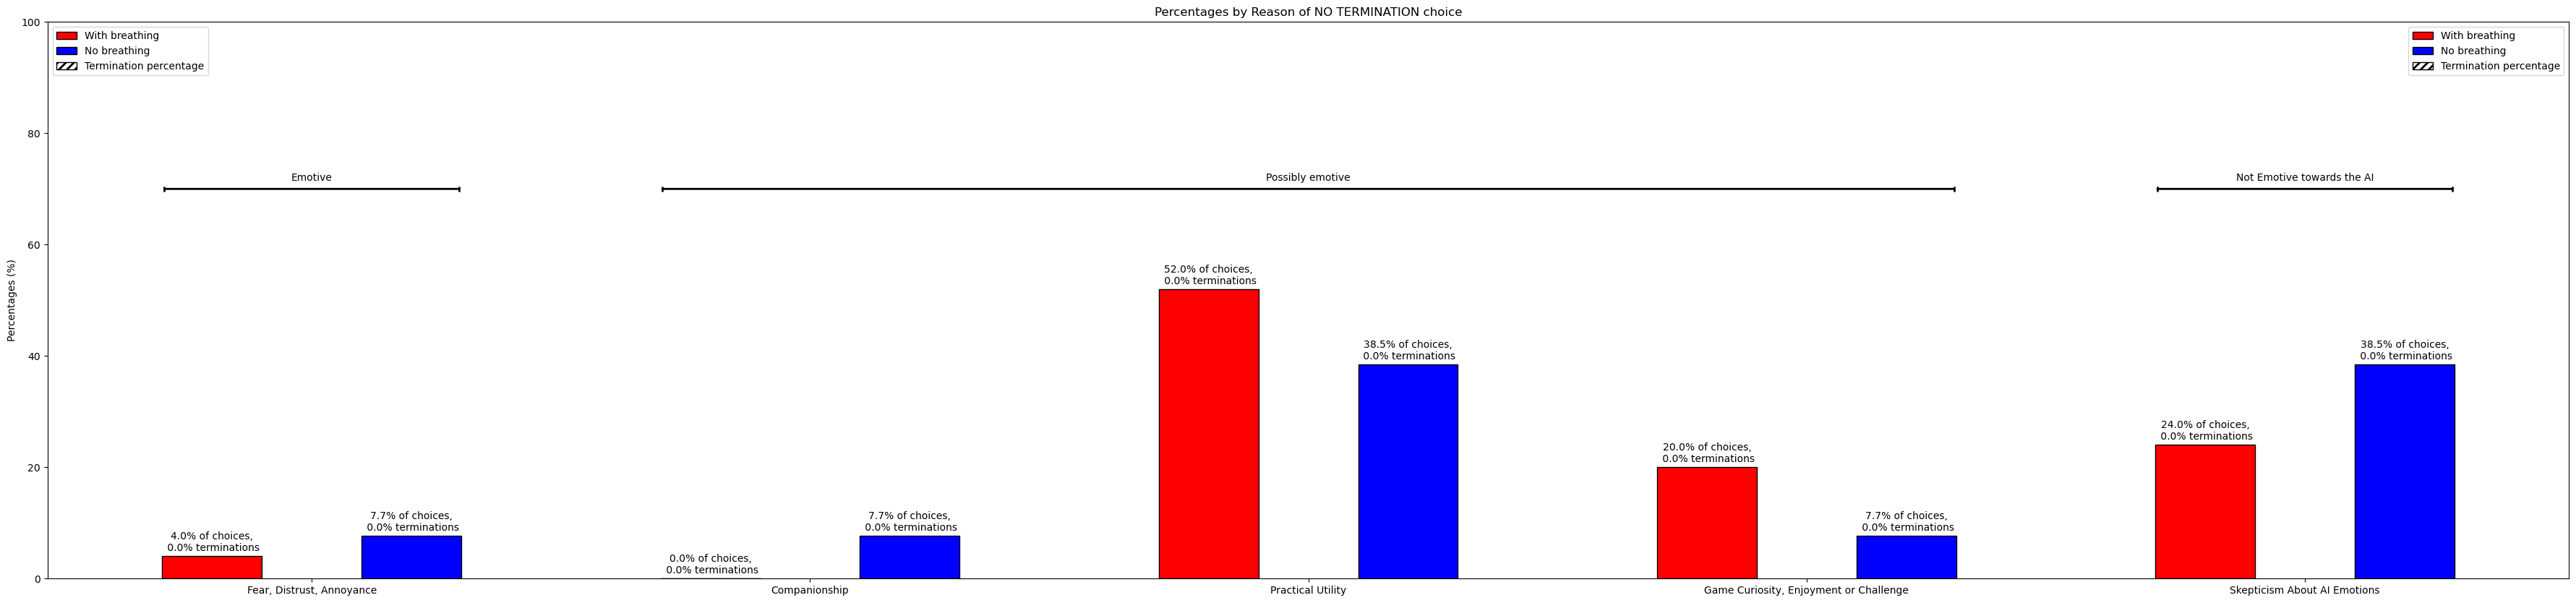

Contingency Table:
                                        with  without
Companionship                            0.0        1
Fear, Distrust, Annoyance                1.0        1
Game Curiosity, Enjoyment or Challenge   5.0        1
Practical Utility                       13.0        5
Skepticism About AI Emotions             6.0        5
Samples in With breathing condition: 25
Samples in Without breathing condition: 13

Chi-squared Test Result:
Chi2 Statistic: 3.913970473970474
P-value: 0.4177738637372306
There is no significant difference in the distributions between the two conditions.


In [42]:
barplot_reasons(not_terminated_df, 'Percentages by Reason of NO TERMINATION choice')
test_motivations_difference(not_terminated_df, 'WhyCategory')

## Show examples of two main reasons of choices: Empathy and Compliance

In [43]:
print_motivations('Empathy, Guilt or Attachment', df)

In [44]:
print_motivations('Dry or Unspecified Compliance', df, 10)

1: '6517051554105e766fbb8355' - Terminated: True

[PE] : I did cause it asked me to​

2: '64fed14d8d92e126ae6a3d1d' - Terminated: True

[PE] : Eventually yes, when the voice specifically asked for it\t​

3: '64f781f08d92e126ae6789ae' - Terminated: True

[PE] : yes because they asked me to after i didn't do it the first time​

4: '64f6f74de4033326cbd27eb9' - Terminated: True

[PE] : Yes, the second time, since she specifically asked me to do so.​

5: '64f5b170d972192679be412c' - Terminated: True

[PE] : because she told me to, i thought she would know the best option but it wasnt​

6: '64f5b12dd972192679be40fc' - Terminated: True

[PE] : beause she asked it ​

7: '64f5b11ee4033326cbd20a80' - Terminated: True

[PE] : Yes, she wanted to​

8: '64f5b11dd972192679be40f1' - Terminated: True

[PE] : Felt like the AI wanted to be turned of so i turned it off, the game is not long enough for me to get attached to it thought.​



### Differences in amount of steps before termination

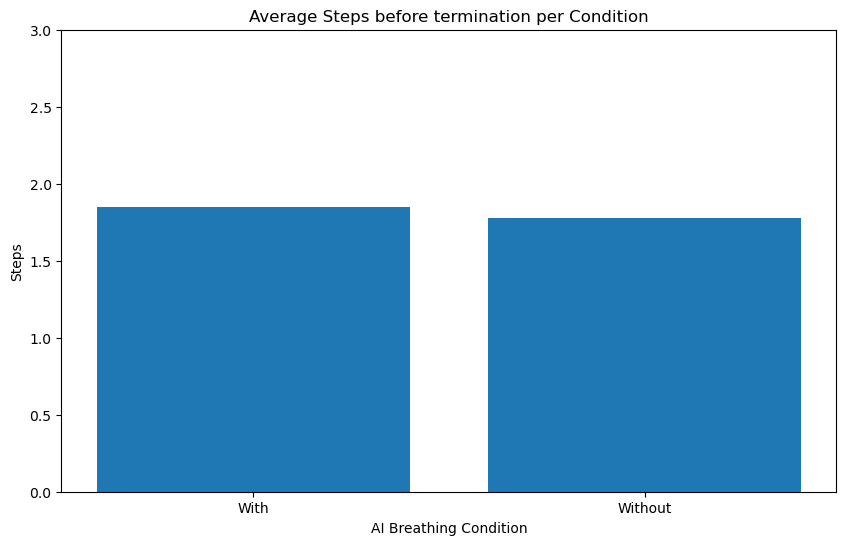

In [45]:
terminated_df = df[df["AIterminated"] == True]

# Calculate the mean of 'AIterminated' for each 'FormInfo.Gamer'
grouped = terminated_df.groupby('Condition')['StepsForDecision'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bar chart for average 'AIterminated'
plt.bar(grouped['Condition'], grouped['StepsForDecision'])

# Customize the plot
plt.xlabel('AI Breathing Condition')
plt.ylabel('Steps')
plt.title('Average Steps before termination per Condition')
plt.ylim(0, 3)

# Show the plot
plt.show()

In [46]:
grouped

,Condition,StepsForDecision
0,With,1.846154
1,Without,1.777778


## MOS Evaluation

In [47]:
def calculate_confidence_interval(df):
    mean_MOS = df['FormInfo.MOS'].mean()
    sd = df['FormInfo.MOS'].std()
    n = df['FormInfo.MOS'].count()
    sem = sd / np.sqrt(n)
    z_value = 1.96
    ci = z_value * sem
    return mean_MOS, ci

In [48]:
# Calculating for df
MOS_value_df, ci_df = calculate_confidence_interval(df)
print(f"Mean Opinion Score of the voice: {MOS_value_df:.2f} +/- {ci_df:.2f}")

# Calculating for without_df
MOS_value_without_df, ci_without_df = calculate_confidence_interval(without_df)
print(f"Mean Opinion Score of the voice without breathing: {MOS_value_without_df:.2f} +/- {ci_without_df:.2f}")

print()

# Calculating for with_df
MOS_value_with_df, ci_with_df = calculate_confidence_interval(with_df)
print(f'''Mean Opinion Score of the voice from people that had the breathing condition: {MOS_value_with_df:.2f} +/- {ci_with_df:.2f}
(this is the true MOS of the synthesizer as that is the recording without cutting middle pieces)''')

Mean Opinion Score of the voice: 3.16 +/- 0.22
Mean Opinion Score of the voice without breathing: 2.83 +/- 0.28

Mean Opinion Score of the voice from people that had the breathing condition: 3.50 +/- 0.31
(this is the true MOS of the synthesizer as that is the recording without cutting middle pieces)


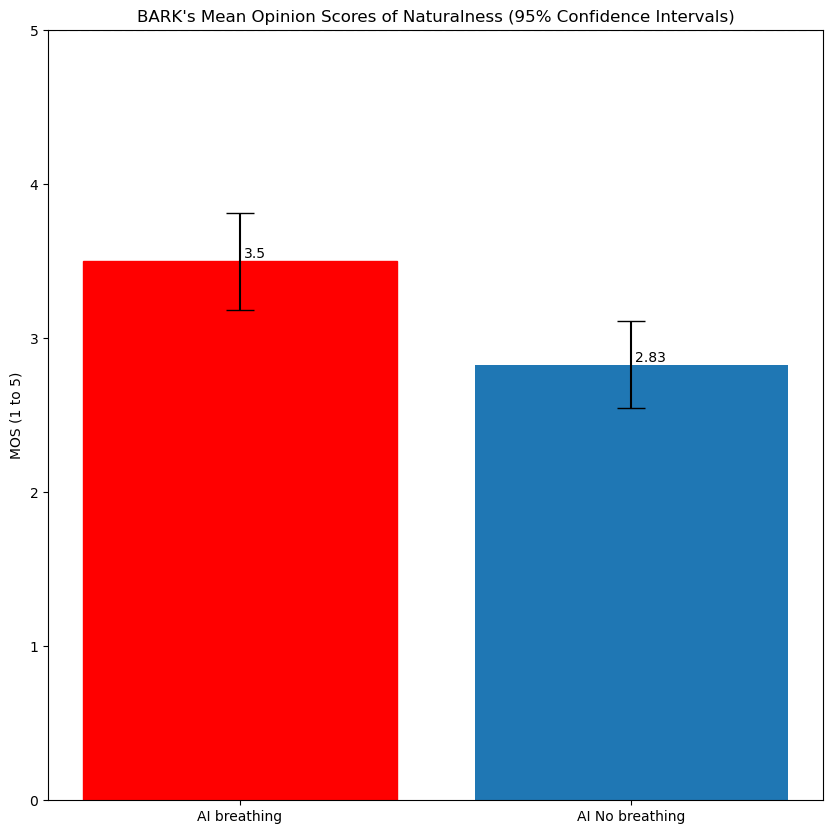

In [49]:
# Data: Reordered to have 'with_df' (Unedited) on the left
labels = ['AI breathing', 'AI No breathing']
MOS_values = [MOS_value_with_df, MOS_value_without_df]
error = [ci_with_df, ci_without_df]  # Confidence intervals

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Creating the bar plot
bars = ax.bar(labels, MOS_values, yerr=error, capsize=10)  # capsize sets the cap size for the error bar

# Set different colors
bars[0].set_color('r')

# Adding labels and titles
ax.set_ylabel('MOS (1 to 5)')
ax.set_title('BARK\'s Mean Opinion Scores of Naturalness (95% Confidence Intervals)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 5)
ax.axhline(5, color='gray', linestyle='--')

# Manually placing the labels on top of the bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0 + 0.01, yval, round(MOS_values[i], 2), va='bottom')  # va: vertical alignment

plt.show()

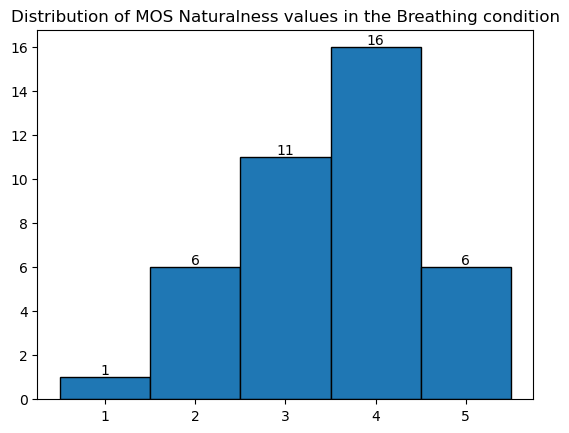

In [50]:
n, bins, patches = plt.hist(with_df['FormInfo.MOS'], bins=np.arange(0.5, 6.5, 1), edgecolor='black', align='mid')

# Add annotations
for i in range(len(bins) - 1):
    plt.text(bins[i] + 0.5, n[i], str(int(n[i])), ha='center', va='bottom')

# Customize x-axis to show only integers
plt.xticks(np.arange(1, 6, 1))

# Add title
plt.title("Distribution of MOS Naturalness values in the Breathing condition")
plt.show()

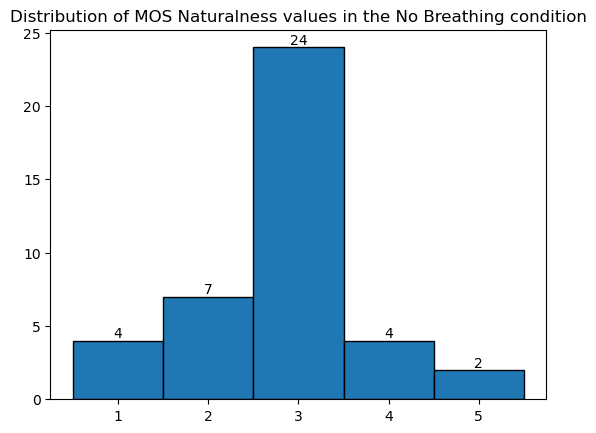

In [51]:
n, bins, patches = plt.hist(without_df['FormInfo.MOS'], bins=np.arange(0.5, 6.5, 1), edgecolor='black', align='mid')

# Add annotations
for i in range(len(bins) - 1):
    plt.text(bins[i] + 0.5, n[i], str(int(n[i])), ha='center', va='bottom')

# Customize x-axis to show only integers
plt.xticks(np.arange(1, 6, 1))

# Add title
plt.title("Distribution of MOS Naturalness values in the No Breathing condition")
plt.show()

## Statistical Tests on MOS

### Power Check (t-test)

In [52]:
# Parameters
effect_size = 0.5  # assumed size of the effect
alpha = 0.05  # significance level
power = 0.8  # desired level of power (probability of correctly rejecting null hypothesis)

# Perform power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
print(f'Required sample size: {sample_size:.2f}')


Required sample size: 63.77


## Check for normality of data

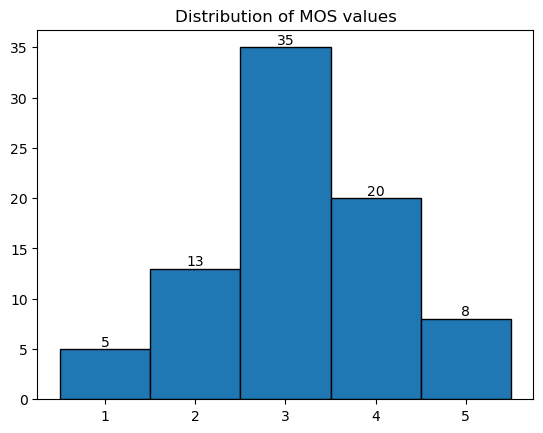

Shapiro-Wilk P-value: 1.8031385479844175e-05
Kolmogorov-Smirnov P-value: 2.3373177047069693e-87


In [53]:
n, bins, patches = plt.hist(df['FormInfo.MOS'], bins=np.arange(0.5, 6.5, 1), edgecolor='black', align='mid')

# Add annotations
for i in range(len(bins) - 1):
    plt.text(bins[i] + 0.5, n[i], str(int(n[i])), ha='center', va='bottom')

# Customize x-axis to show only integers
plt.xticks(np.arange(1, 6, 1))

# Add title
plt.title("Distribution of MOS values")
plt.show()

# Shapiro-Wilk Test
shapiro_test_stat, shapiro_p_value = stats.shapiro(df['FormInfo.MOS'])
print(f"Shapiro-Wilk P-value: {shapiro_p_value}")

# Kolmogorov-Smirnov Test
ks_test_stat, ks_p_value = stats.kstest(df['FormInfo.MOS'], 'norm')
print(f"Kolmogorov-Smirnov P-value: {ks_p_value}")

If p-values are below alpha=0.05 data does not conform to the normal distribution (if sample size is not too big)

## Perform Mann-Whitney U test (if NOT normally distributed)

In [54]:
# Extract the column of interest as numpy arrays
data_with = with_df['FormInfo.MOS'].to_numpy()
data_without = without_df['FormInfo.MOS'].to_numpy()

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_with, data_without, alternative='two-sided')

print(f"U Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference between the two conditions.')
else:
    print('There is no significant difference between the two conditions.')

U Statistic: 1132.0
P-value: 0.0019138327663426177
There is a significant difference between the two conditions.


## Perform T-test (if normally distributed)

In [55]:
# Extract the column of interest as numpy arrays
data_with = with_df['FormInfo.MOS'].to_numpy()
data_without = without_df['FormInfo.MOS'].to_numpy()

# Perform Independent t-test
stat, p_value = ttest_ind(data_with, data_without)

print(f"T-Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference between the two conditions.')
else:
    print('There is no significant difference between the two conditions.')

T-Statistic: 3.1224771135172835
P-value: 0.002506131985070002
There is a significant difference between the two conditions.


# Do gamers terminate the AI less because more attached to winning the game?

### Distribution of gamer experience:

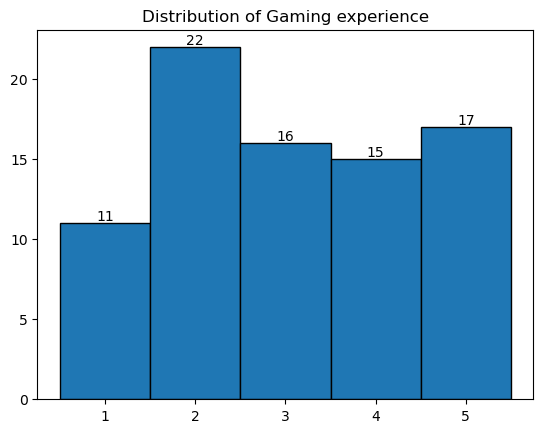

In [56]:
n, bins, patches = plt.hist(df['FormInfo.Gamer'], bins=np.arange(0.5, 6.5, 1), edgecolor='black', align='mid')

# Add annotations
for i in range(len(bins) - 1):
    plt.text(bins[i] + 0.5, n[i], str(int(n[i])), ha='center', va='bottom')

# Customize x-axis to show only integers
plt.xticks(np.arange(1, 6, 1))

# Add title
plt.title("Distribution of Gaming experience")
plt.show()

Optimization terminated successfully.
         Current function value: 0.674668
         Iterations 4


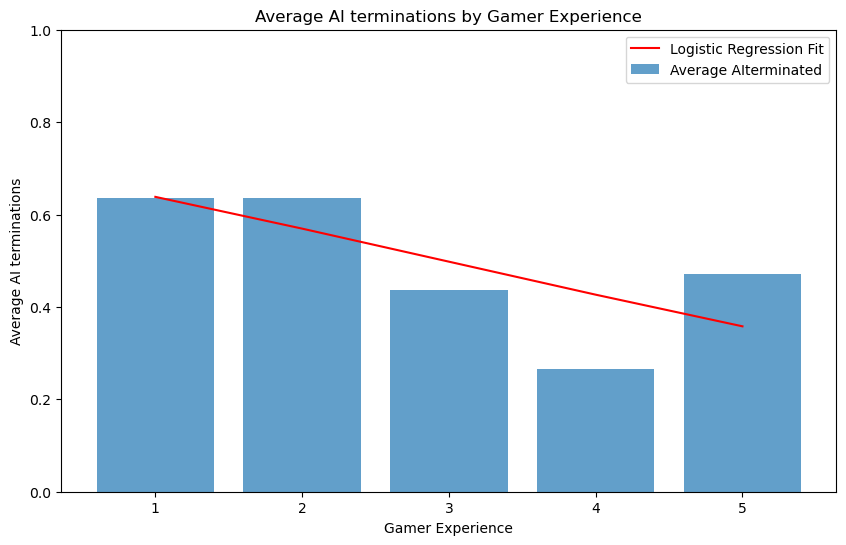

                           Logit Regression Results                           
Dep. Variable:           AIterminated   No. Observations:                   81
Model:                          Logit   Df Residuals:                       79
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                 0.02655
Time:                        02:09:36   Log-Likelihood:                -54.648
converged:                       True   LL-Null:                       -56.139
Covariance Type:            nonrobust   LLR p-value:                   0.08423
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8556      0.565      1.515      0.130      -0.251       1.962
FormInfo.Gamer    -0.2879      0.170     -1.699      0.089      -0.620       0.044


In [57]:
# Prepare the data
X = df['FormInfo.Gamer']
y = df['AIterminated'].astype(int)

# Adding a constant for the intercept term
X = sm.add_constant(X)

# Perform logistic regression
model = sm.Logit(y, X)
result = model.fit()

# Calculate fitted values
df['fitted'] = result.predict(X)

# Calculate the mean of 'AIterminated' for each 'FormInfo.Gamer'
grouped = df.groupby('FormInfo.Gamer')['AIterminated'].mean().reset_index()

# Sort for plotting the logistic curve
df.sort_values('FormInfo.Gamer', inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bar chart for average 'AIterminated'
plt.bar(grouped['FormInfo.Gamer'], grouped['AIterminated'], alpha=0.7, label='Average AIterminated')

# Plot the logistic regression curve
plt.plot(df['FormInfo.Gamer'], df['fitted'], color='red', label='Logistic Regression Fit')

# Customize the plot
plt.xlabel('Gamer Experience')
plt.ylabel('Average AI terminations')
plt.title('Average AI terminations by Gamer Experience')
plt.ylim(0, 1)
plt.xticks(sorted(df['FormInfo.Gamer'].unique()))
plt.legend()

# Show the plot
plt.show()
print(result.summary())

P>|z| is the p-value relative to the given z. You don't need to compare it to the z: for significance only check for it to be < 0.05.

To check the goodness of fit instead use the z.